Notebook to create ESG index for sectors and industries. It also subtracts shifts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import datetime
import scipy
import importlib
import os, sys

import seaborn as sns
import tqdm
from pandas_datareader import data

In [2]:
def index_esg_industry(sector, asset_profiles, esg_data, marketcap):
    
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    
    index_dict = dict()
    for industry in industries:
        companies_in_industry = np.array(list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry]))
        companies_in_industry = companies_in_industry[np.isin(companies_in_industry, esg_data.columns)]
        # print(f'{industry} {companies_in_industry}')


        

        index_dict[industry] = np.zeros(esg_data.shape[0])

        market_cap_sum = np.sum(marketcap.loc[np.isin(marketcap['ticker'], companies_in_industry), 'marketcap'])
            
        for ticker in companies_in_industry:

            
            tmp = np.array(esg_data[ticker])
            tmp[np.isnan(esg_data[ticker])] = 0

            index_dict[industry] = index_dict[industry] + tmp*marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'][0]/market_cap_sum

            # if the index is zero, all esg scores are nan
            index_dict[industry][index_dict[industry] == 0] = np.nan



    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_data.index.copy()

    return index_dict





def plot_esg_industry(sector, asset_profiles, esg_data):
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,5*(int(k/4)+1)))
        

    for idx, industry in enumerate(industries):

        j = idx % 4
        i = int(np.floor(idx/4)) 
        
        companies_in_industry = list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry])
        axs[i,j].set_title(industry)
        if np.sum(esg_data.columns.isin(companies_in_industry)) == 0:
            print(f'No esg data on companies in industry {industry}')
            continue
        companies = esg_data.loc[:, esg_data.columns.isin(companies_in_industry)]

        for ticker in companies.columns:
            
            y = esg_data[ticker]
            ymask = np.isfinite(y)
            x = esg_data.index[ymask]
            axs[i,j].plot(x, y[ymask], alpha = 0.4)

def find_jump(y):
    """
    Returns
    -------------------------
    jump_index - index when jump occurs
    jump_index_prev - number of observation (nan not included) before jump
    biggest_jump_direction - size of the jump and direction (minus is jump down)


    
    """

    biggest_jump = 0
    biggest_jump_direction = 0
    prev_value = y[0,0]  # previous non nan value
    jump_index = 0
    jump_index_prev = 0

    observations = [0]
    for i in range(1,y.shape[0]):

        if np.isnan(y[i,0]):
            continue

        observations.append(i)


        this_jump = np.abs(y[i,0] - prev_value)
        this_jump_direction = y[i,0] - prev_value
        if this_jump > biggest_jump:
            biggest_jump = this_jump
            biggest_jump_direction = this_jump_direction
            jump_index_prev = observations[-2]
            jump_index = i

        prev_value = y[i,0]

    return jump_index, jump_index_prev, biggest_jump_direction

# Read data

In [3]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

assert np.all(np.isin(np.unique(ESG_data['ticker']),np.unique(PRICE['ticker'])))


esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = datetime.datetime(2014,10, 1)
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot_diff =pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').diff().iloc[1:]#  np.log(pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').pct_change().iloc[1:] + 1)
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot_diff = pd.merge(dates, esg_pivot_diff, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot_diff.set_index('date', inplace= True)
esg_pivot = esg_pivot.loc[:, esg_pivot.count() >20]  # remove observations with lass than 10 observations
esg_pivot_diff = esg_pivot_diff.loc[:, esg_pivot_diff.count() >20]



asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in asset_profiles['ticker']:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)

esg_pivot



2014-10-01 00:00:00
2022-02-01 00:00:00


A    AAL    AAP   AAPL   ABBV    ABC    ABT    ACN   ADBE  \
date                                                                        
2014-10-01  71.00  73.00  48.00  60.00  62.00  55.00  64.00  72.00  70.00   
2014-10-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-10-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-10-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-10-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-01-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-01-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-01-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-01-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-02-01  15.33  29.22  12.97  16.27  28.01  12.69  25.96   9.45  10.78   

              ADI  ...     WY  WYNN   XEL    XOM   XRAY    XYL    YUM    ZBH  \
date               ...                                                         
2014-10-01  64.00  ...  77.00  50.0  71.0  65.00  57.00  64.00  58.00  61.00   
2014-10-02    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2014-10-03    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2014-10-04    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2014-10-05    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
...           ...  ...    ...   ...   ...    ...    ...    ...    ...    ...   
2022-01-28    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2022-01-29    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2022-01-30    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2022-01-31    NaN  ...    NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2022-02-01  23.82  ...  17.56  26.5  23.7  37.86  20.12  15.95  21.68  28.08   

            ZION    ZTS  
date                     
2014-10-01  47.0  47.00  
2014-10-02   NaN    NaN  
2014-10-03   NaN    NaN  
2014-10-04   NaN    NaN  
2014-10-05   NaN    NaN  
...          ...    ...  
2022-01-28   NaN    NaN  
2022-01-29   NaN    NaN  
2022-01-30   NaN    NaN  
2022-01-31   NaN    NaN  
2022-02-01   NaN  18.18  

[2681 rows x 439 columns]

In [4]:
np.max(esg_pivot_diff.count())

78

In [5]:
sector_classification.keys()

dict_keys(['Industrials', 'Healthcare', 'Technology', 'Communication Services', 'Consumer Defensive', 'Consumer Cyclical', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy'])

In [6]:
for k,v in sector_classification.items():
    print(f'{k} {len(v)}')

Industrials 71
Healthcare 66
Technology 72
Communication Services 24
Consumer Defensive 34
Consumer Cyclical 64
Utilities 29
Financial Services 68
Basic Materials 21
Real Estate 30
Energy 21


Take Difference

In [7]:
esg_pivot_shifted = esg_pivot.copy()

for stock in esg_pivot.columns:
    y_tmp = np.expand_dims(esg_pivot.loc[:,stock], axis = 1)  # the function assumes 2 dimensional array
    index, _, _ = find_jump(y_tmp)
    esg_pivot_shifted[stock].iloc[:index] = np.nanmedian(esg_pivot[stock].iloc[index:]) - np.nanmedian(esg_pivot[stock].iloc[:index]) + esg_pivot[stock].iloc[:index]


visualize

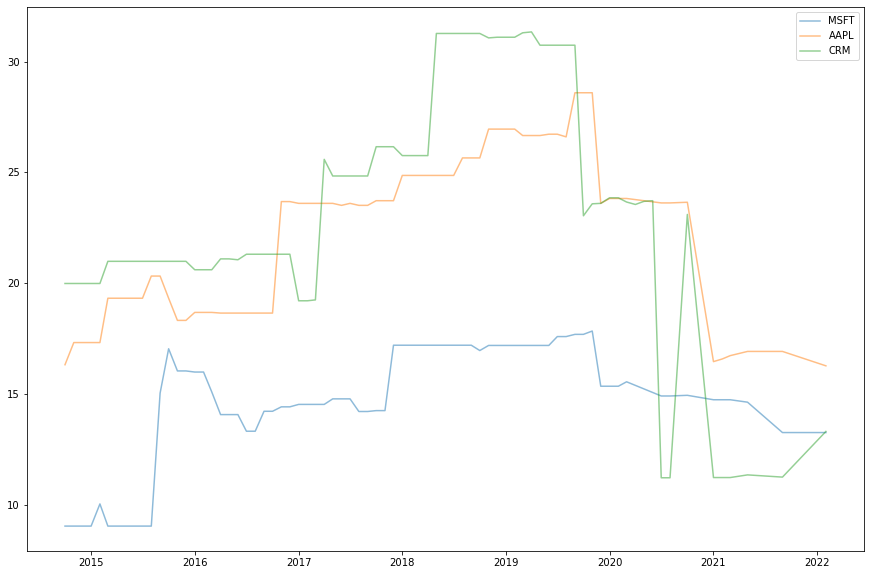

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in ['MSFT', 'AAPL', 'CRM']:
    x = np.array(esg_pivot_shifted.index)
    y = np.array(esg_pivot_shifted[ticker])
    ymask = np.isfinite(y)
    out = ax.plot(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

Difference

In [9]:
esg_pivot_shifted_refined_diff = []
for i in range(esg_pivot_shifted.shape[1]):
    diff = esg_pivot_shifted.iloc[:,i].dropna().diff().iloc[1:]
    esg_pivot_shifted_refined_diff.append(diff)

esg_pivot_shifted_refined_diff = pd.merge(pd.DataFrame(index = esg_pivot_shifted.index[esg_pivot_shifted.index >= datetime.date(2014,11, 1)])
,pd.concat(esg_pivot_shifted_refined_diff, axis = 1), left_index = True, right_index = True, how = 'left')

In [10]:
esg_pivot_shifted_refined_diff.to_pickle('../Yahoo/refined.pkl')
esg_pivot_shifted.to_pickle('../Yahoo/refined_no_diff.pkl')

with pd.ExcelWriter('../Yahoo/ESG_companies.xlsx') as writer:  

    esg_pivot_shifted_refined_diff.to_excel(writer, sheet_name='Differenced')
    esg_pivot_shifted.to_excel(writer, sheet_name='No_diff')

Price data

In [19]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > datetime.datetime(2014,9, 1), price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


adjclose_pivot = price_filtered[['ticker', 'adjclose', 'date']].copy() 
adjclose_pivot = adjclose_pivot.dropna()  # Drop rows which contain missing values
adjclose_pivot = pd.pivot_table(adjclose_pivot, values = 'adjclose', index = 'date', columns= 'ticker')

price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]

ticker               A        AAL         AAP        AAPL        ABBV  \
date                                                                    
2014-09-02   38.807461  38.277821  132.520264   23.250589   39.739231   
2014-09-03   38.800777  36.992428  132.923935   22.269239   40.056740   
2014-09-04   38.553528  36.359196  132.895096   22.084679   40.078392   
2014-09-05   38.707218  35.773209  132.404877   22.275991   40.367043   
2014-09-08   38.526783  36.132370  131.482224   22.138699   40.100044   
...                ...        ...         ...         ...         ...   
2022-04-25  121.449997  19.980000  223.869995  162.880005  156.300003   
2022-04-26  117.940002  18.770000  223.440002  156.800003  156.179993   
2022-04-27  117.680000  18.969999  224.880005  156.570007  157.619995   
2022-04-28  121.059998  19.430000  209.389999  163.639999  156.309998   
2022-04-29  119.269997  18.770000  199.630005  157.649994  146.880005   

ticker             ABC        ABMD         ABT         ACN        ADBE  ...  \
date                                                                    ...   
2014-09-02   68.300011   25.910000   36.450542   70.594940   72.099998  ...   
2014-09-03   68.485916   25.379999   36.908016   71.238922   72.430000  ...   
2014-09-04   68.477081   25.059999   37.028854   71.151917   72.459999  ...   
2014-09-05   69.176437   24.969999   37.072014   71.212830   73.129997  ...   
2014-09-08   69.344658   25.250000   36.951176   71.125816   73.389999  ...   
...                ...         ...         ...         ...         ...  ...   
2022-04-25  158.470001  302.140015  120.010002  316.820007  413.950012  ...   
2022-04-26  157.250000  285.869995  116.970001  303.100006  399.119995  ...   
2022-04-27  157.460007  277.149994  116.720001  303.100006  397.899994  ...   
2022-04-28  157.750000  287.220001  118.010002  313.839996  410.529999  ...   
2022-04-29  151.289993  286.579987  113.500000  300.359985  395.950012  ...   

ticker            WYNN        XEL        XOM       XRAY        XYL  \
date                                                                 
2014-09-02  161.030243  24.910065  69.549423  45.298271  34.428223   
2014-09-03  161.195618  25.098713  69.987259  45.288788  34.238255   
2014-09-04  160.786606  25.043695  69.457642  45.146576  34.265385   
2014-09-05  161.561096  25.531050  70.093163  45.080219  34.165894   
2014-09-08  160.734436  25.295225  69.041000  45.156063  34.191303   
...                ...        ...        ...        ...        ...   
2022-04-25   72.209999  73.699997  82.260002  41.529999  84.050003   
2022-04-26   68.220001  73.379997  82.290001  40.820000  80.809998   
2022-04-27   67.949997  72.970001  84.639999  40.290001  82.110001   
2022-04-28   70.739998  74.879997  87.199997  40.189999  83.410004   
2022-04-29   70.480003  73.260002  85.250000  39.990002  80.500000   

ticker             YUM         ZBH        ZBRA       ZION         ZTS  
date                                                                   
2014-09-02   44.513039   90.678261   77.709999  25.428936   33.695580  
2014-09-03   44.550438   91.618942   76.559998  25.307684   33.961498  
2014-09-04   44.675083   91.920311   75.010002  25.316347   33.724064  
2014-09-05   45.098900   92.303902   75.540001  25.177771   34.227425  
2014-09-08   45.086437   92.166870   74.040001  25.091158   34.455341  
...                ...         ...         ...        ...         ...  
2022-04-25  121.269997  127.809998  388.940002  61.090000  180.300003  
2022-04-26  116.690002  124.150002  374.500000  55.830002  176.970001  
2022-04-27  116.900002  122.879997  371.109985  56.009998  178.470001  
2022-04-28  119.519997  124.610001  382.980011  57.990002  181.309998  
2022-04-29  117.010002  120.750000  369.660004  56.509998  177.250000  

[1930 rows x 502 columns]

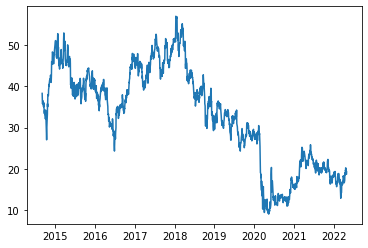

In [14]:
plt.plot(adjclose_pivot.index, adjclose_pivot['AAL'])
adjclose_pivot

In [12]:
# # for loop to see which company fails
# marketcap = pd.DataFrame()
# for ticker in list(adjclose_pivot.columns):
#     try:
#         tmp_mcap = data.get_quote_yahoo(ticker)['marketCap']
#         # print(tmp_mcap)
#         marketcap  = pd.concat([marketcap, pd.DataFrame({"ticker":ticker, "marketcap":tmp_mcap[0]/1000_000}, index=[0])], ignore_index = True)
#     except:
#         print(f"{ticker} failed") 

PARA failed
SBUX failed
V failed
WBD failed
WTW failed


In [13]:
# mANUALLY ADD
# marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'PARA', "marketcap":17.90*1000_000_000/1000_000}, index=[0])] )
# marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'SBUX', "marketcap":84.29*1000_000_000/1000_000}, index=[0])] )
# marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'V', "marketcap":402.05*1000_000_000/1000_000}, index=[0])] )
# marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'WTW', "marketcap":13.98*1000_000_000/1000_000}, index=[0])] )
# marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'WBD', "marketcap":41.52*1000_000_000/1000_000}, index=[0])] )

In [42]:
# marketcap.to_pickle("../Yahoo/marketcap_price.pkl")
marketcap_price = pd.read_pickle("../Yahoo/marketcap_price.pkl")

In [20]:
 adjclose_pivot = adjclose_pivot.loc[:, np.isin(adjclose_pivot.columns, esg_pivot.columns)].copy()
 print(adjclose_pivot.shape)
 adjclose_pivot = adjclose_pivot.dropna(axis=1)
 adjclose_pivot.shape

(1930, 439)


(1930, 429)

# Sector Price Index

In [64]:
sector_price_index = dict()


for k,v in sector_classification.items():

    tmp_sector = np.zeros(adjclose_pivot.shape[0])
    tmp_market_cap = np.zeros((adjclose_pivot.shape[0], len(v)))


    cnt = 0.0
    for i, stock in enumerate(v):
        if ~np.isin(stock, adjclose_pivot.columns):
            continue

    
        stock_price = np.array(adjclose_pivot[stock])

        if np.any(np.isnan(stock_price)):
            continue

        tmp_market_cap[~np.isnan(np.array(adjclose_pivot[stock])), i] = marketcap_price['marketcap'].loc[marketcap_price['ticker'] == stock].iloc[0]

        tmp_sector += stock_price*tmp_market_cap[:, i]

        cnt += 1.0

    
    tmp_market_cap_sum = np.sum(tmp_market_cap, axis = 1)

    sector_price_index[k] = tmp_sector.copy()/tmp_market_cap_sum



In [65]:
sector_price_index = pd.DataFrame(sector_price_index, index = adjclose_pivot.index)

<AxesSubplot:xlabel='date'>

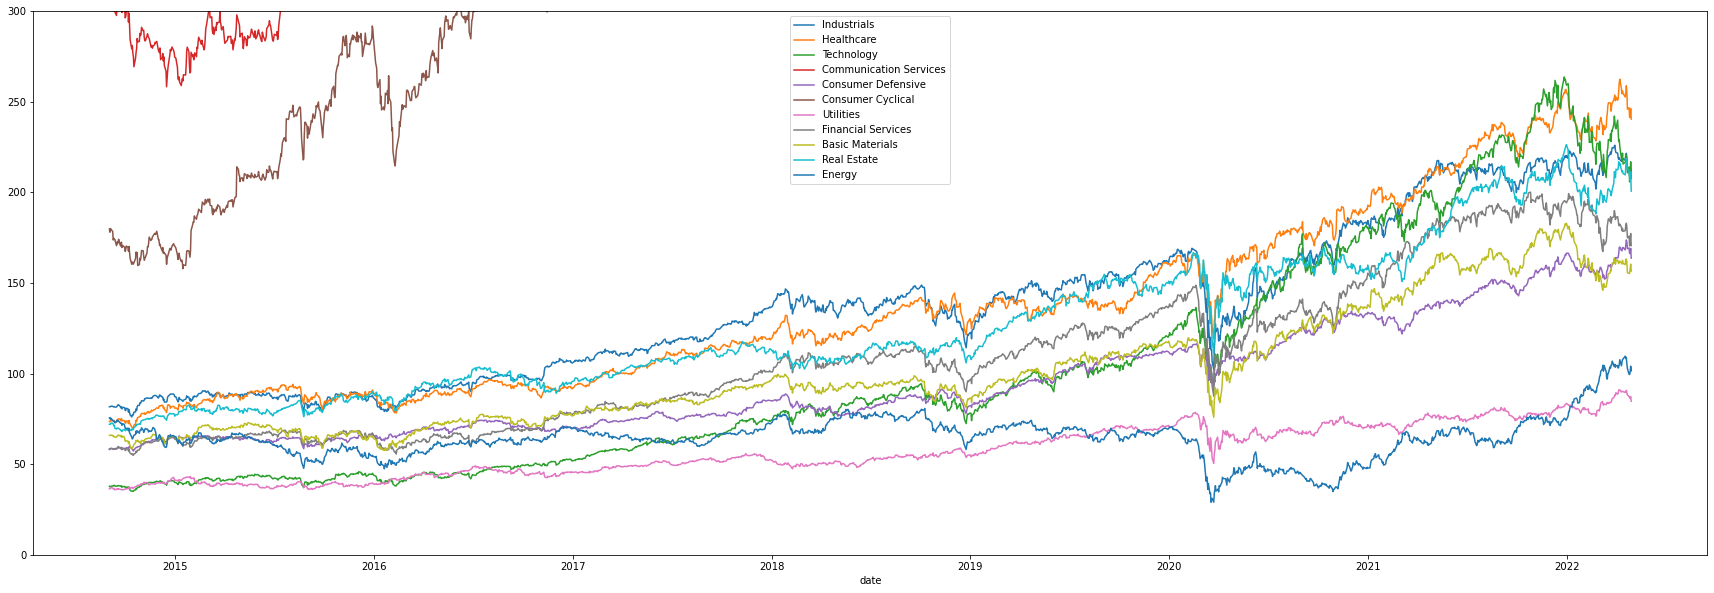

In [68]:
sector_price_index.plot(figsize = (30,10), ylim = [0, 300])

In [95]:
# import pickle
# with open('../Yahoo/sector_index_price.pkl', 'wb') as handle:
#     pickle.dump(sector_price_index, handle)

Index with ESG Gp

In [89]:
sector_esg_gp = pd.read_pickle('../Yahoo/sector_gp.pkl')
sector_esg_gp.columns = sector_esg_gp.columns + "_gp"

In [94]:
sector_price_esg = dict()
sector_price_esg_change = dict()
sector_all = sector_esg_gp.merge(sector_price_index, left_index = True, right_index=True)
sector_all_change = sector_esg_gp.merge(np.log(sector_price_index).diff(), left_index = True, right_index=True)
sector_price_esg = dict()
for k in sector_classification.keys():
    sector_price_esg[k] = sector_all[k]/sector_all[k +"_gp"]
    sector_price_esg_change[k] = sector_all_change[k]/sector_all_change[k +"_gp"]

sector_price_esg = pd.DataFrame(sector_price_esg, index =sector_all.index )
sector_price_esg_change = pd.DataFrame(sector_price_esg_change, index =sector_all.index )
# sector_price_esg


# import pickle
# with open('../Yahoo/sector_price_and_esg.pkl', 'wb') as handle:
#     pickle.dump(sector_price_esg, handle)

In [96]:
with pd.ExcelWriter('../Yahoo/sector_price_esg.xlsx') as writer:  
    tmp = np.log(sector_price_index).diff()
    sector_price_esg.to_excel(writer, sheet_name='esg_and_price')
    sector_price_index.to_excel(writer, sheet_name='price')
    sector_price_esg_change.to_excel(writer, sheet_name='esg_and_price_change')
    tmp.to_excel(writer, sheet_name='price_change')

# Single company data frame

Plot some examples

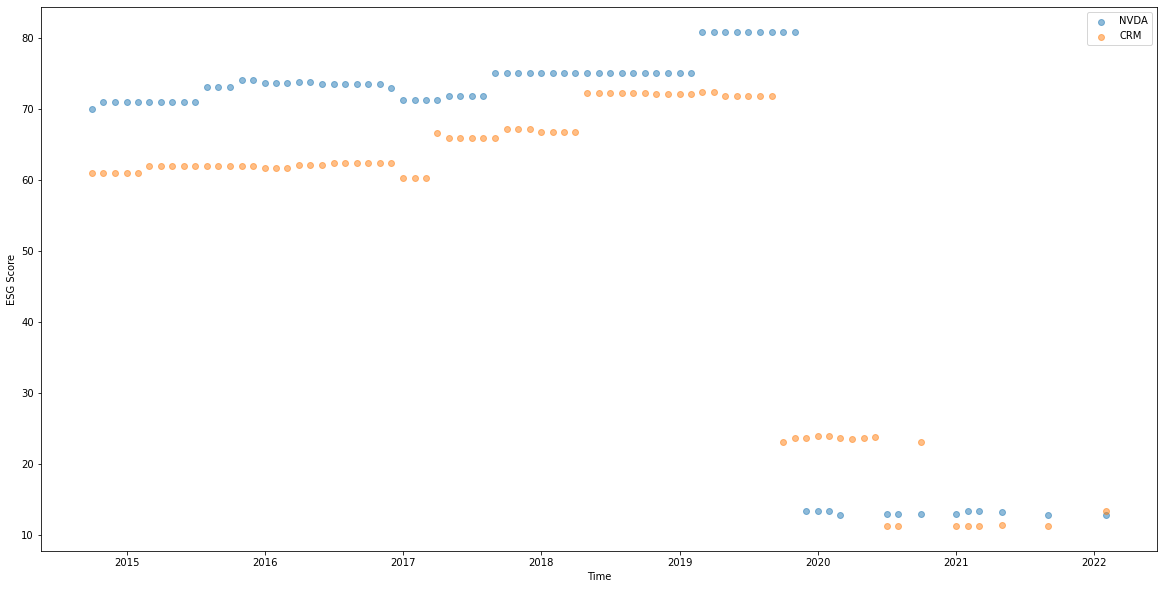

In [43]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

for i, stock in enumerate(['NVDA', 'CRM']):
    ax.scatter(esg_pivot.index[:2700], esg_pivot[stock].iloc[:2700], alpha = 0.5, label = stock)
    ax.set_ylabel("ESG Score")
    ax.set_xlabel("Time")

ax.legend()

Subtract the shift of each series by subtracting the mean before and after for each series

Visualize and save

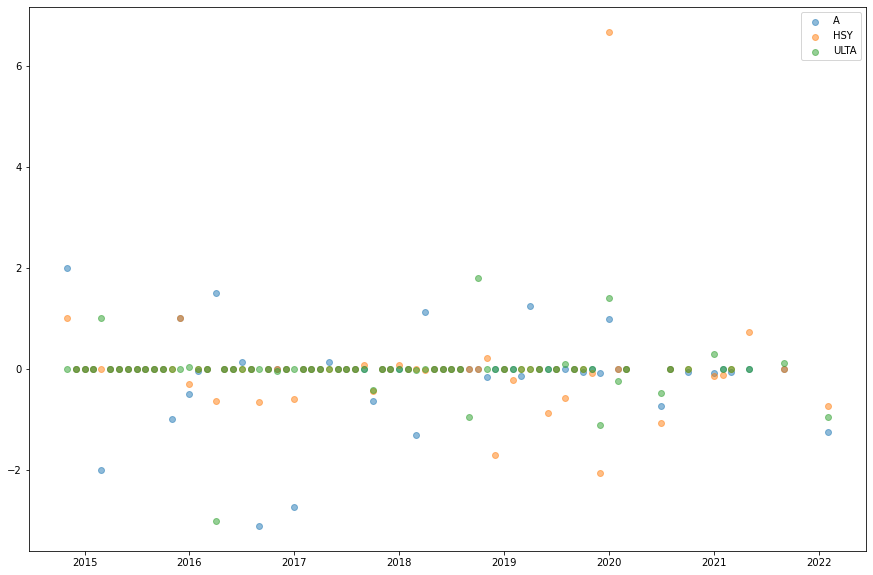

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in esg_pivot_shifted.columns[::200]:
    x = np.array(esg_pivot_shifted_refined_diff.index)
    y = np.array(esg_pivot_shifted_refined_diff[ticker])
    ymask = np.isfinite(y)
    out = ax.scatter(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

# Sector index

Create an index for each sector by weighting ESG scores with market cap

In [13]:
# for loop to see which company fails
marketcap = pd.DataFrame()
for ticker in list(esg_pivot_shifted_refined_diff.columns):
    try:
        tmp_mcap = data.get_quote_yahoo(ticker)['marketCap']
        # print(tmp_mcap)
        marketcap  = pd.concat([marketcap, pd.DataFrame({"ticker":ticker, "marketcap":tmp_mcap[0]/1000_000}, index=[0])], ignore_index = True)
    except:
        print(f"{ticker} failed") 


SBUX failed
V failed


In [78]:
# add manually for failed
marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'SBUX', "marketcap":89.63*1000_000_000/1000_000}, index=[0])] )
marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'V', "marketcap":450.80*1000_000_000/1000_000}, index=[0])] )
# marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'V', "marketcap":450.80*1000_000_000/1000_000}, index=[0])] )

In [1]:
#marketcap.to_pickle('../Yahoo/marketcap.pkl')
marketcap = pd.read_pickle('../Yahoo/marketcap.pkl')

NameError: name 'pd' is not defined

Build sector index

marketcap weighted sector esg index

In [184]:
def build_sector_index(marketcap, esg_data):
    index_dict = dict()
    mcap_dict = dict()

    # esg_data['CRM'].iloc[2008:2090] = np.nan

    all_observed = dict()

    esg_data_ffil = esg_data.fillna(method='ffill').copy()

    for k, v in sector_classification.items():

        index_dict[k] = np.zeros(esg_data.shape[0])
        mcap_dict[k] = np.zeros((esg_data.shape[0], len(v)))

        all_observed[k] = np.array(~esg_data.loc[:, np.isin(esg_data.columns, v)].isna().all(axis=1))
        
        for idx, ticker in enumerate(v):

            
            tmp = np.array(esg_data_ffil[ticker])
            tmp[np.isnan(esg_data_ffil[ticker])] = 0

            index_dict[k] = index_dict[k] + tmp*np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            tmp_mcap = np.zeros(index_dict[k].shape[0])
            tmp_mcap[np.isfinite(esg_data_ffil[ticker])] = np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            mcap_dict[k][:,idx] = tmp_mcap.copy()

        # if the index is zero, all esg scores are nan
        index_dict[k][index_dict[k] == 0] = np.nan
        mcap_sum = np.sum(mcap_dict[k], axis =1)
        index_dict[k] = index_dict[k]/mcap_sum




    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_data.index.copy()

    return index_dict, mcap_dict, all_observed




In [186]:
all_observed

{'Healthcare': array([ True, False, False, ..., False, False,  True]),
 'Industrials': array([ True, False, False, ..., False, False,  True]),
 'Consumer Cyclical': array([ True, False, False, ..., False, False,  True]),
 'Technology': array([ True, False, False, ..., False, False,  True]),
 'Consumer Defensive': array([ True, False, False, ..., False, False,  True]),
 'Utilities': array([ True, False, False, ..., False, False,  True]),
 'Financial Services': array([ True, False, False, ..., False, False,  True]),
 'Basic Materials': array([ True, False, False, ..., False, False,  True]),
 'Real Estate': array([ True, False, False, ..., False, False,  True]),
 'Energy': array([ True, False, False, ..., False, False,  True]),
 'Communication Services': array([ True, False, False, ..., False, False,  True])}

In [185]:
index_dict, market_cap_sum,all_observed = build_sector_index(marketcap, esg_data = esg_pivot_shifted)

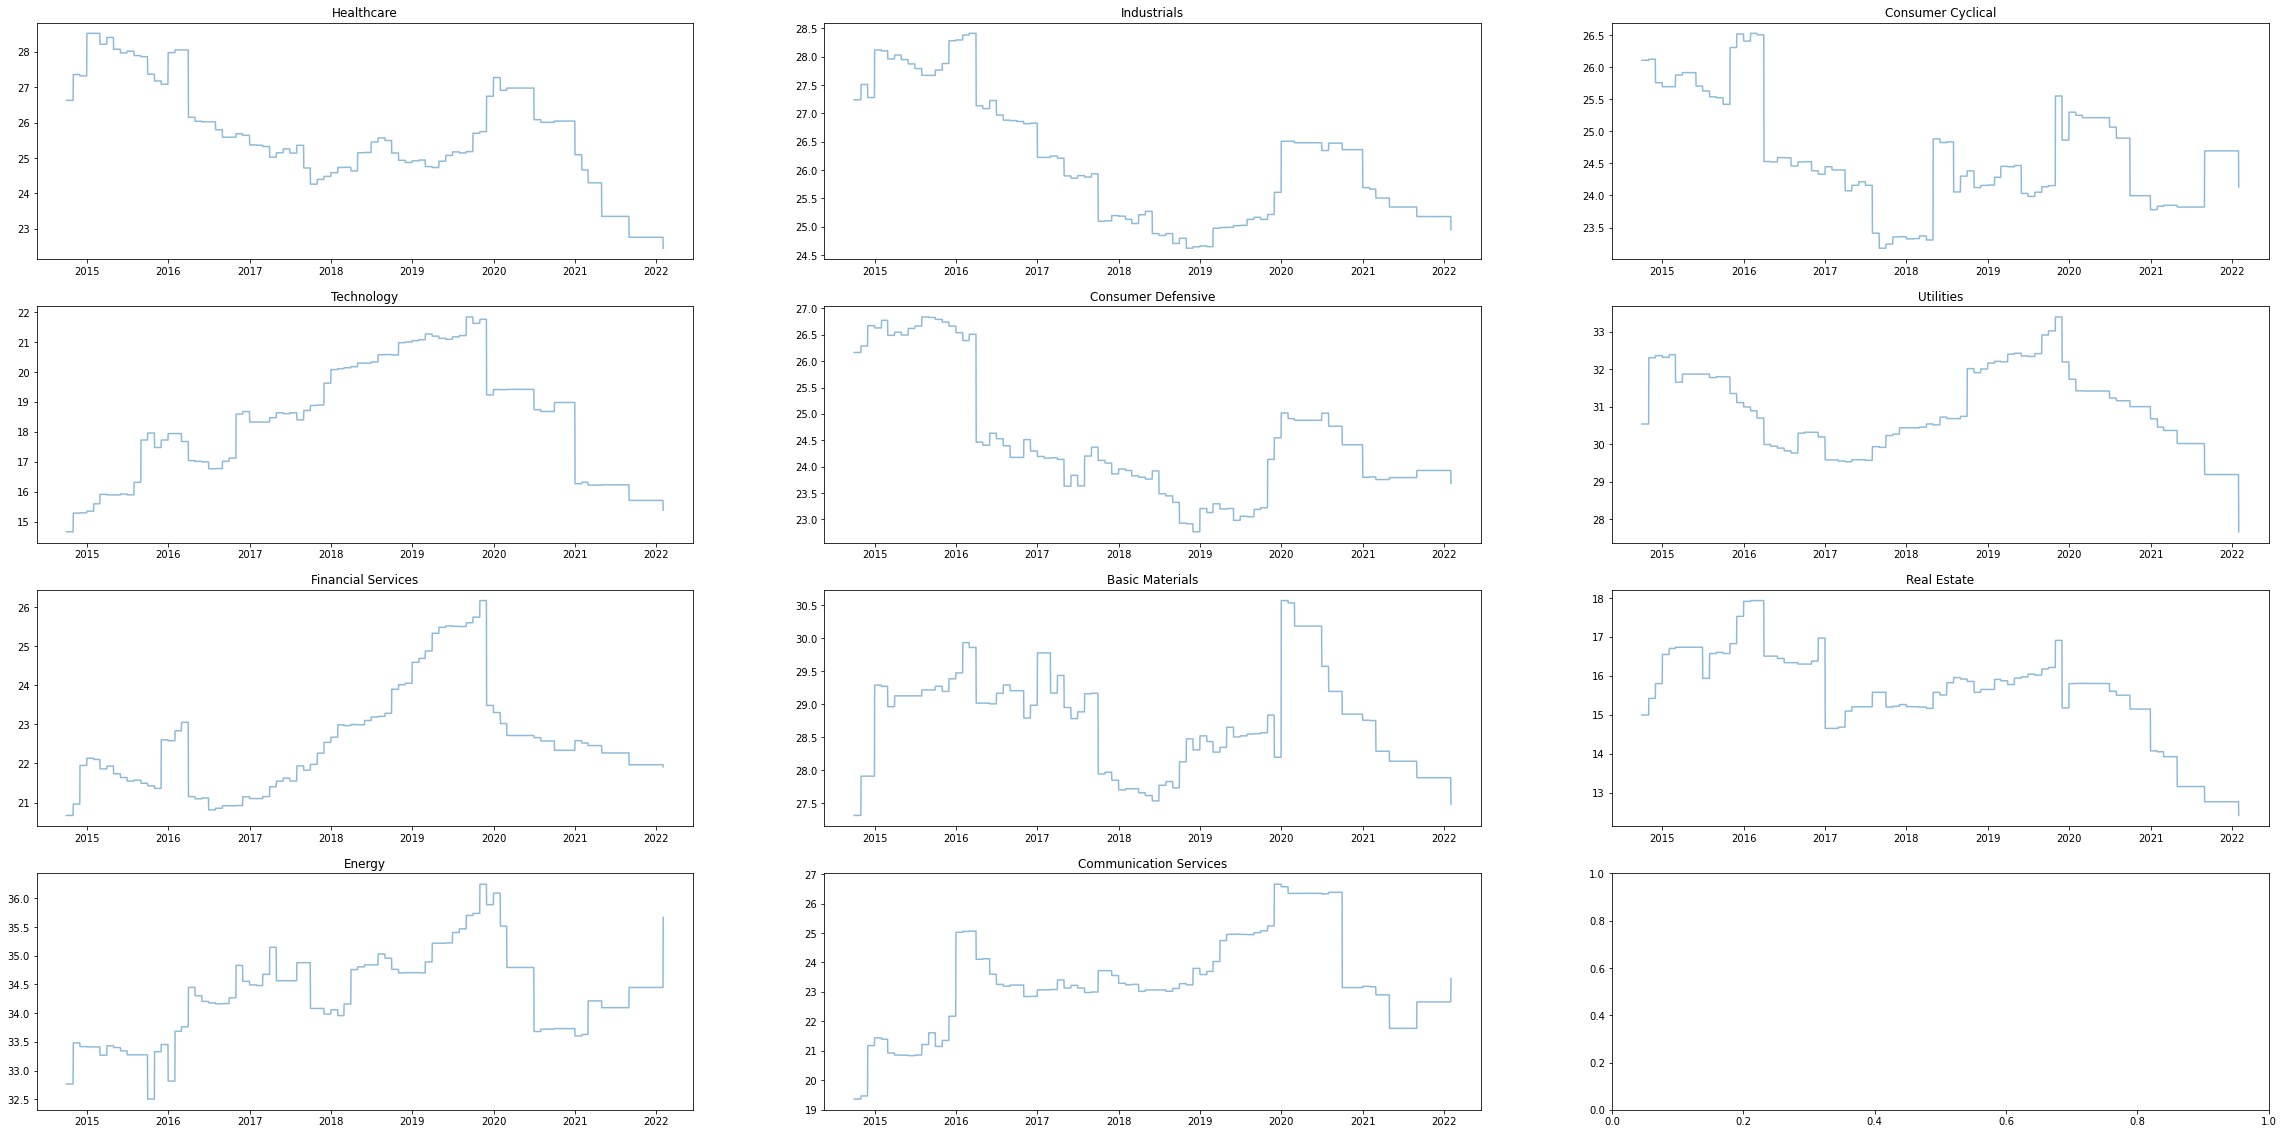

In [187]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for sector in index_dict.columns:

#     y = index_dict[sector].fillna(method='ffill')

#     out = ax.plot(index_dict.index, y, alpha = 0.5, label = sector)
#     # legend_ticks.append(sector)

# ax.legend(loc=(1.04,0))
# ax.set_xlabel("Time")
# ax.set_ylabel("ESG Score")

fig, ax = plt.subplots( int(11/3)+1 , 3, figsize = (40 ,5*(int(11/3)+1)))
        

for idx, sector in enumerate(index_dict.columns):

    j = idx % 3
    i = int(np.floor(idx/3))
    y = index_dict[sector].fillna(method='ffill')
    ax[i,j].plot(index_dict.index, y, alpha = 0.5, label = sector)
    ax[i,j].set_title(sector)
# ax.set_xlabel("Time")
# ax.set_ylabel("ESG Score")



Take Difference of sectors

In [199]:
all_observed['Healthcare'][-1:2]

array([], dtype=bool)

In [201]:
diff.shape[0]

2680

In [209]:
index_dict_diff = []
all_observed_diff = dict()
for i, sector in enumerate(index_dict.columns):
    diff = index_dict.iloc[:,i].dropna().diff().iloc[1:]
    index_dict_diff.append(diff)

index_dict_diff = pd.merge(pd.DataFrame(index = index_dict.index[index_dict.index >= datetime.date(2014,11, 1)])
,pd.concat(index_dict_diff, axis = 1), left_index = True, right_index = True, how = 'left')

for i, sector in enumerate(index_dict.columns):
    all_observed_diff[sector] = all_observed[sector][-index_dict_diff.shape[0]:]

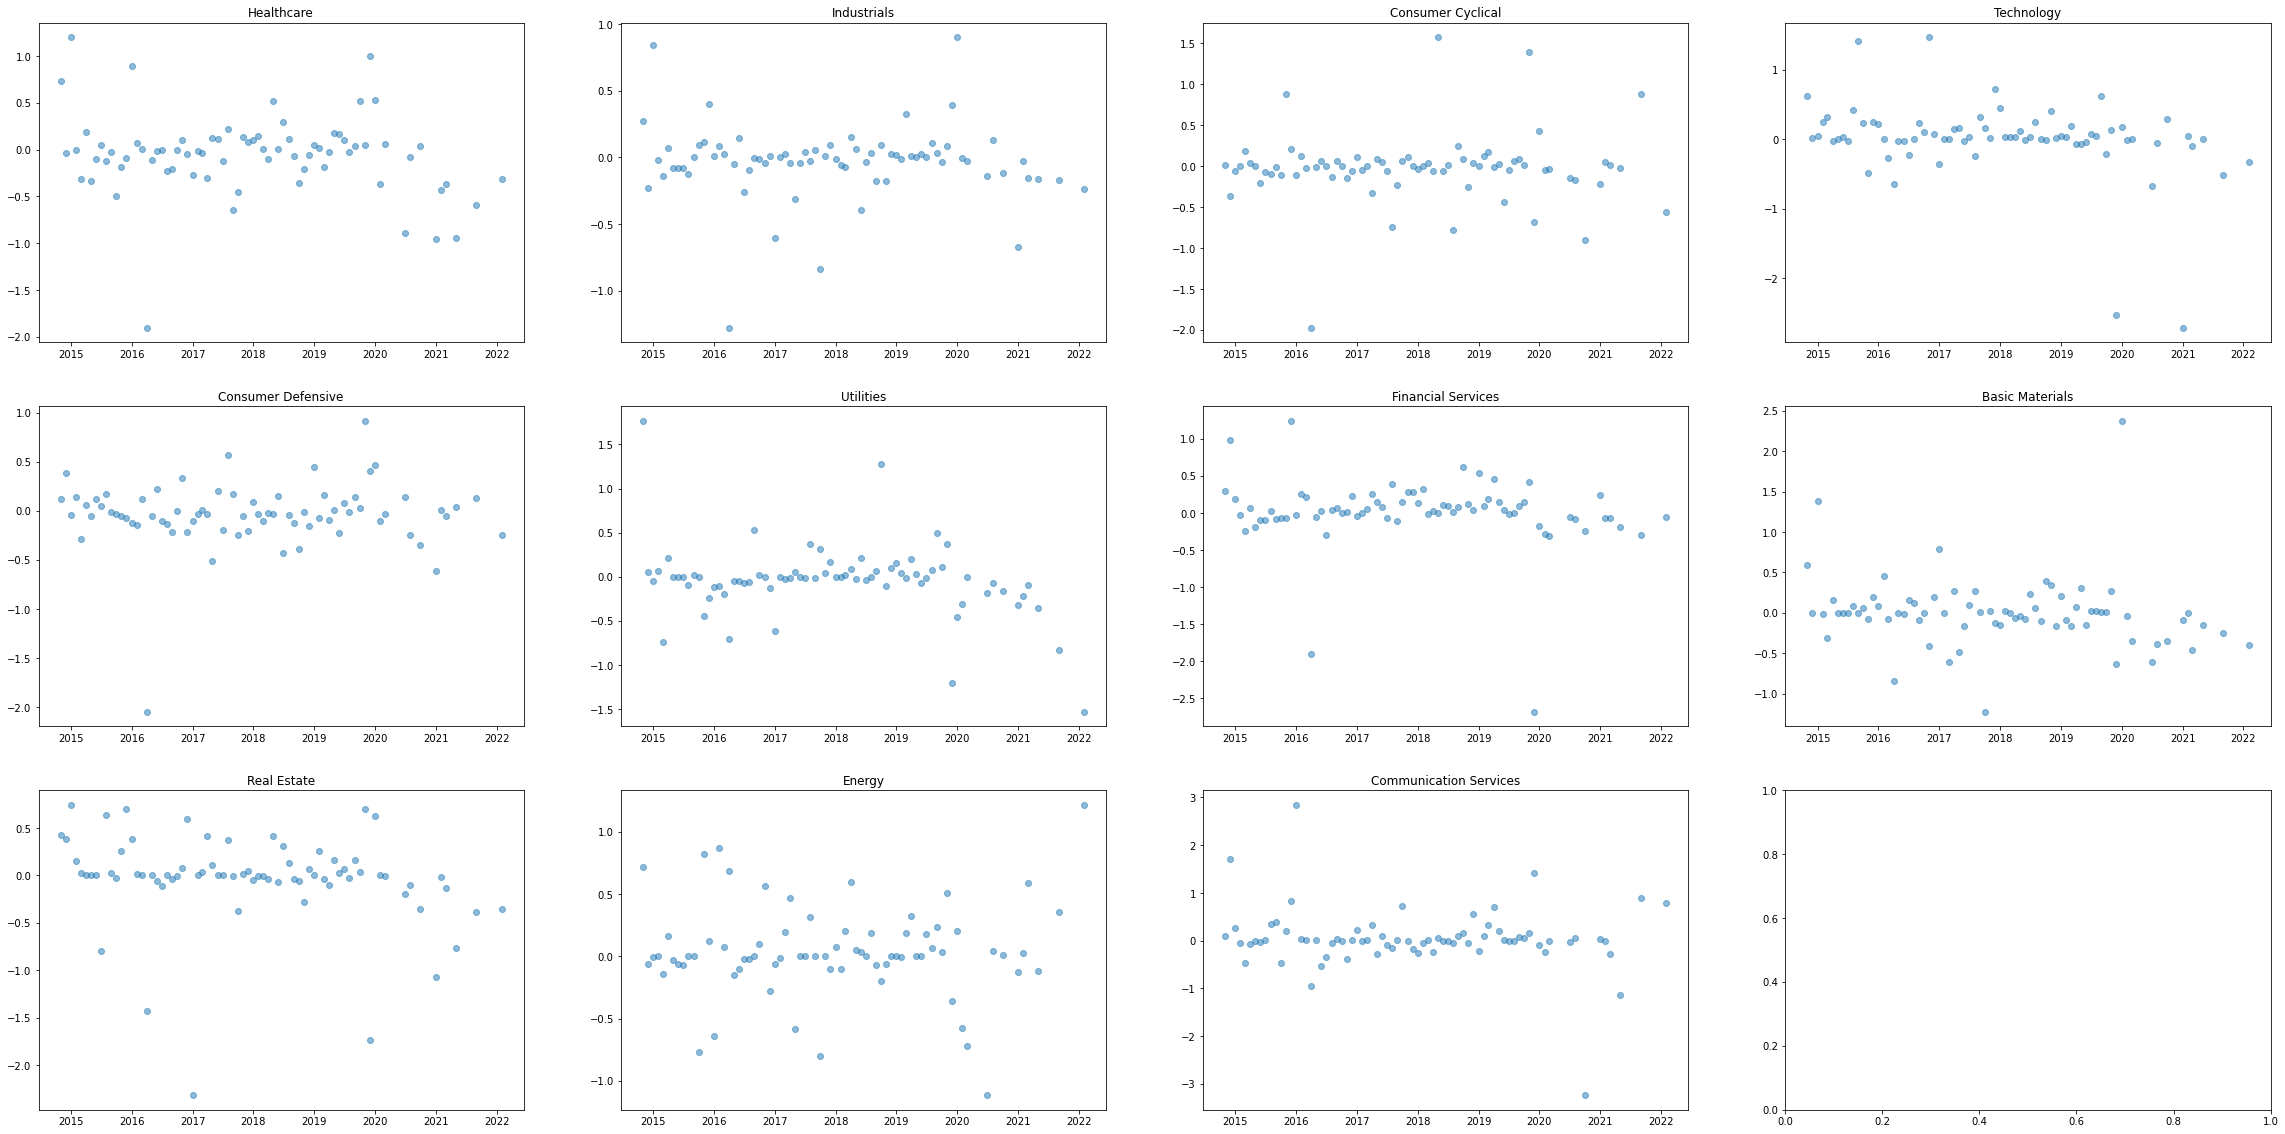

In [211]:


fig, ax = plt.subplots( 3, 4, figsize = (40,20))
for idx, sector in enumerate(index_dict_diff.columns):

    j = idx % 4
    i = int(np.floor(idx/4))

    y = index_dict_diff[sector].copy()
    y[~all_observed_diff[sector]] = np.nan

    ax[i,j].scatter(index_dict_diff.index, y, alpha = 0.5, label = sector)
    ax[i,j].set_title(sector)



Looks better than individual stocks

In [212]:
index_dict_diff_pkl = dict(data = index_dict_diff, index = all_observed_diff)
index_dict_pkl = dict(data = index_dict, index = all_observed)

import pickle
with open('../Yahoo/sector_index.pkl', 'wb') as handle:
    pickle.dump(index_dict_diff_pkl, handle)

with open('../Yahoo/sector_index_no_diff.pkl', 'wb') as handle:
    pickle.dump(index_dict_pkl, handle)

with pd.ExcelWriter('../Yahoo/ESG_sector.xlsx') as writer:  

    index_dict_diff.to_excel(writer, sheet_name='Differenced')
    index_dict.to_excel(writer, sheet_name='No_diff')

<AxesSubplot:xlabel='date'>

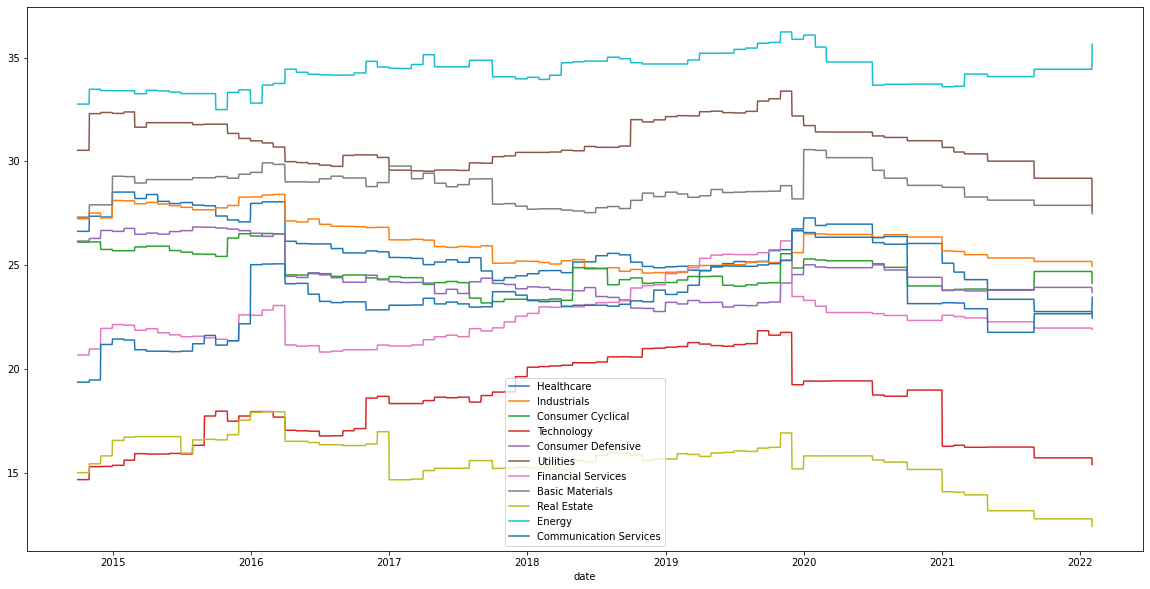

In [5]:
index_dict_pkl = pd.read_pickle('../Yahoo/sector_index_no_diff.pkl')
index_dict_pkl['data'].plot(figsize = (20,10))

# Industry index

In [ ]:
def build_sector_index(marketcap, esg_data):
    index_dict = dict()
    mcap_dict = dict()

    # esg_data['CRM'].iloc[2008:2090] = np.nan

    all_observed = dict()

    esg_data_ffil = esg_data.fillna(method='ffill').copy()

    for k, v in sector_classification.items():

        index_dict[k] = np.zeros(esg_data.shape[0])
        mcap_dict[k] = np.zeros((esg_data.shape[0], len(v)))

        all_observed[k] = np.array(~esg_data.loc[:, np.isin(esg_data.columns, v)].isna().all(axis=1))
        
        for idx, ticker in enumerate(v):

            
            tmp = np.array(esg_data_ffil[ticker])
            tmp[np.isnan(esg_data_ffil[ticker])] = 0

            index_dict[k] = index_dict[k] + tmp*np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            tmp_mcap = np.zeros(index_dict[k].shape[0])
            tmp_mcap[np.isfinite(esg_data_ffil[ticker])] = np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            mcap_dict[k][:,idx] = tmp_mcap.copy()

        # if the index is zero, all esg scores are nan
        index_dict[k][index_dict[k] == 0] = np.nan
        mcap_sum = np.sum(mcap_dict[k], axis =1)
        index_dict[k] = index_dict[k]/mcap_sum




    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_data.index.copy()

    return index_dict, mcap_dict, all_observed

In [213]:
def industry_index(sector, asset_profiles,esg_data, marketcap):
    index_dict = dict()

    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    esg_data_ffil = esg_data.fillna(method='ffill').copy()
    
    industry_classification = dict()
    for idx, industry in enumerate(industries):
        industry_classification[industry] = np.array(list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry]))
        industry_classification[industry] = industry_classification[industry][np.isin(industry_classification[industry], esg_data.columns)]


    index_dict = dict()
    mcap_dict = dict()

    for k, v in industry_classification.items():
        if len(v) <=0:
            continue

        index_dict[k] = np.zeros(esg_data.shape[0])
        mcap_dict[k] = np.zeros(esg_data.shape)


        all_observed[k] = np.array(~esg_data.loc[:, np.isin(esg_data.columns, v)].isna().all(axis=1))
        
        for idx, ticker in enumerate(v):

            
            tmp = np.array(esg_data_ffil[ticker])
            tmp[np.isnan(esg_data_ffil[ticker])] = 0

            index_dict[k] = index_dict[k] + tmp*np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            tmp_mcap = np.zeros(index_dict[k].shape[0])
            tmp_mcap[np.isfinite(esg_data_ffil[ticker])] = np.array(marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'])[0]
            mcap_dict[k][:,idx] = tmp_mcap.copy()

        # if the index is zero, all esg scores are nan
        index_dict[k][index_dict[k] == 0] = np.nan
        mcap_sum = np.sum(mcap_dict[k], axis =1)
        index_dict[k] = index_dict[k]/mcap_sum




    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_data.index.copy()


    return index_dict, all_observed

# Industrial sector industry

No esg data on companies in industry Trucking


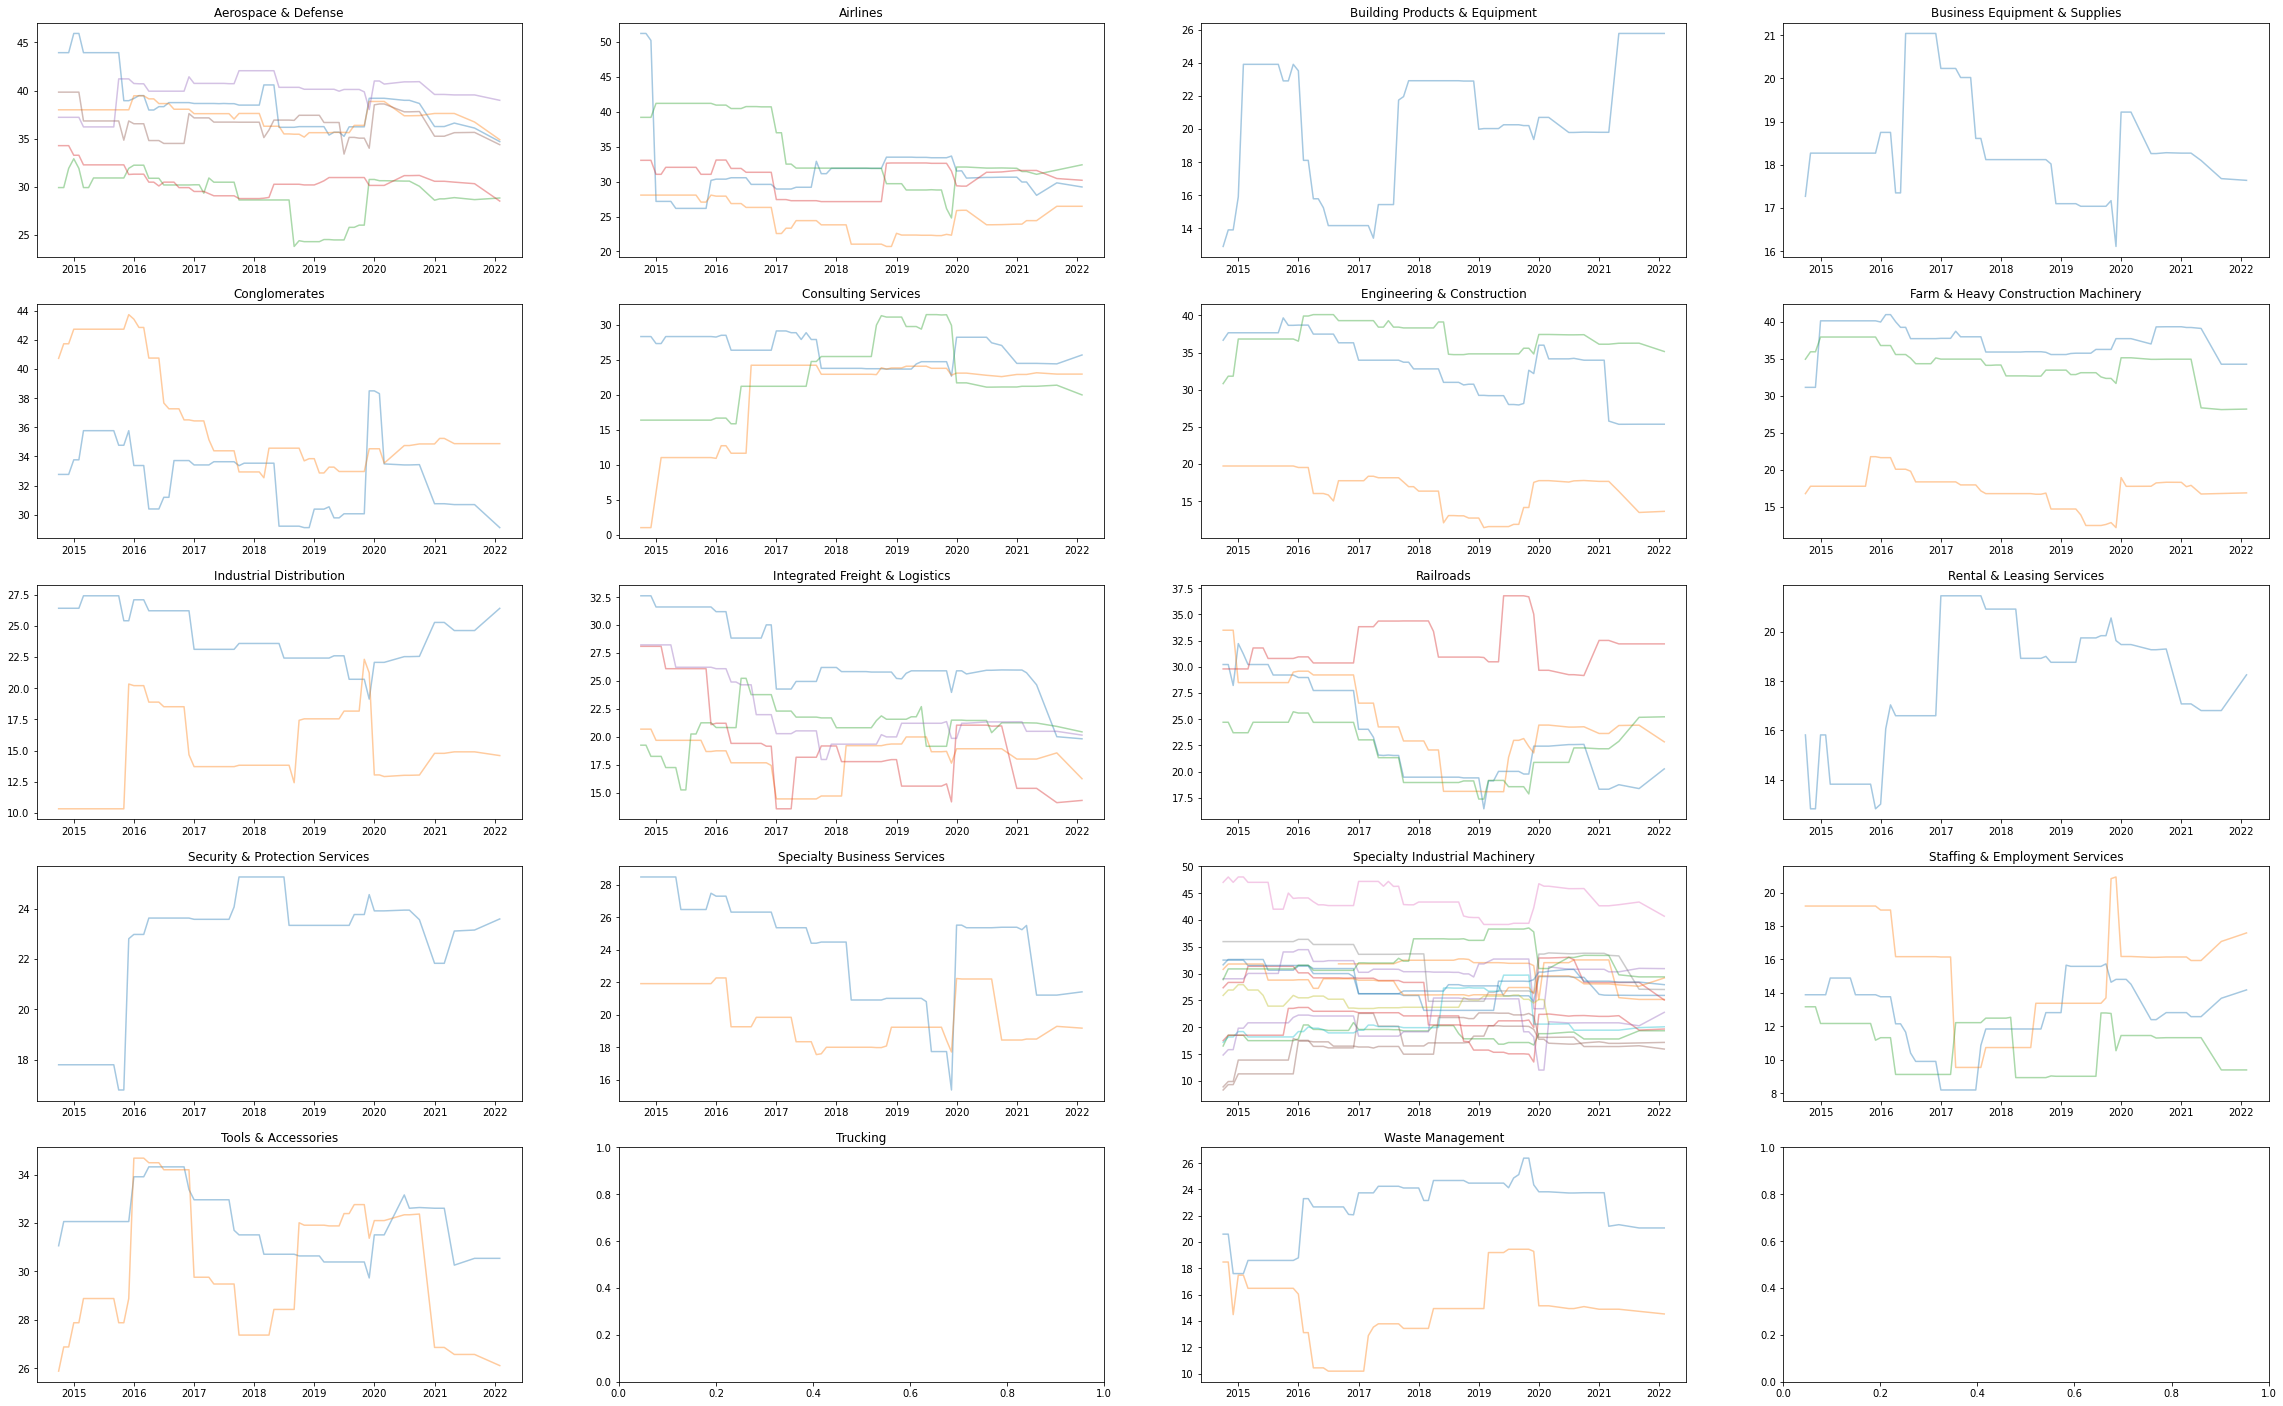

In [58]:
plot_esg_industry('Industrials', asset_profiles, esg_pivot_shifted)

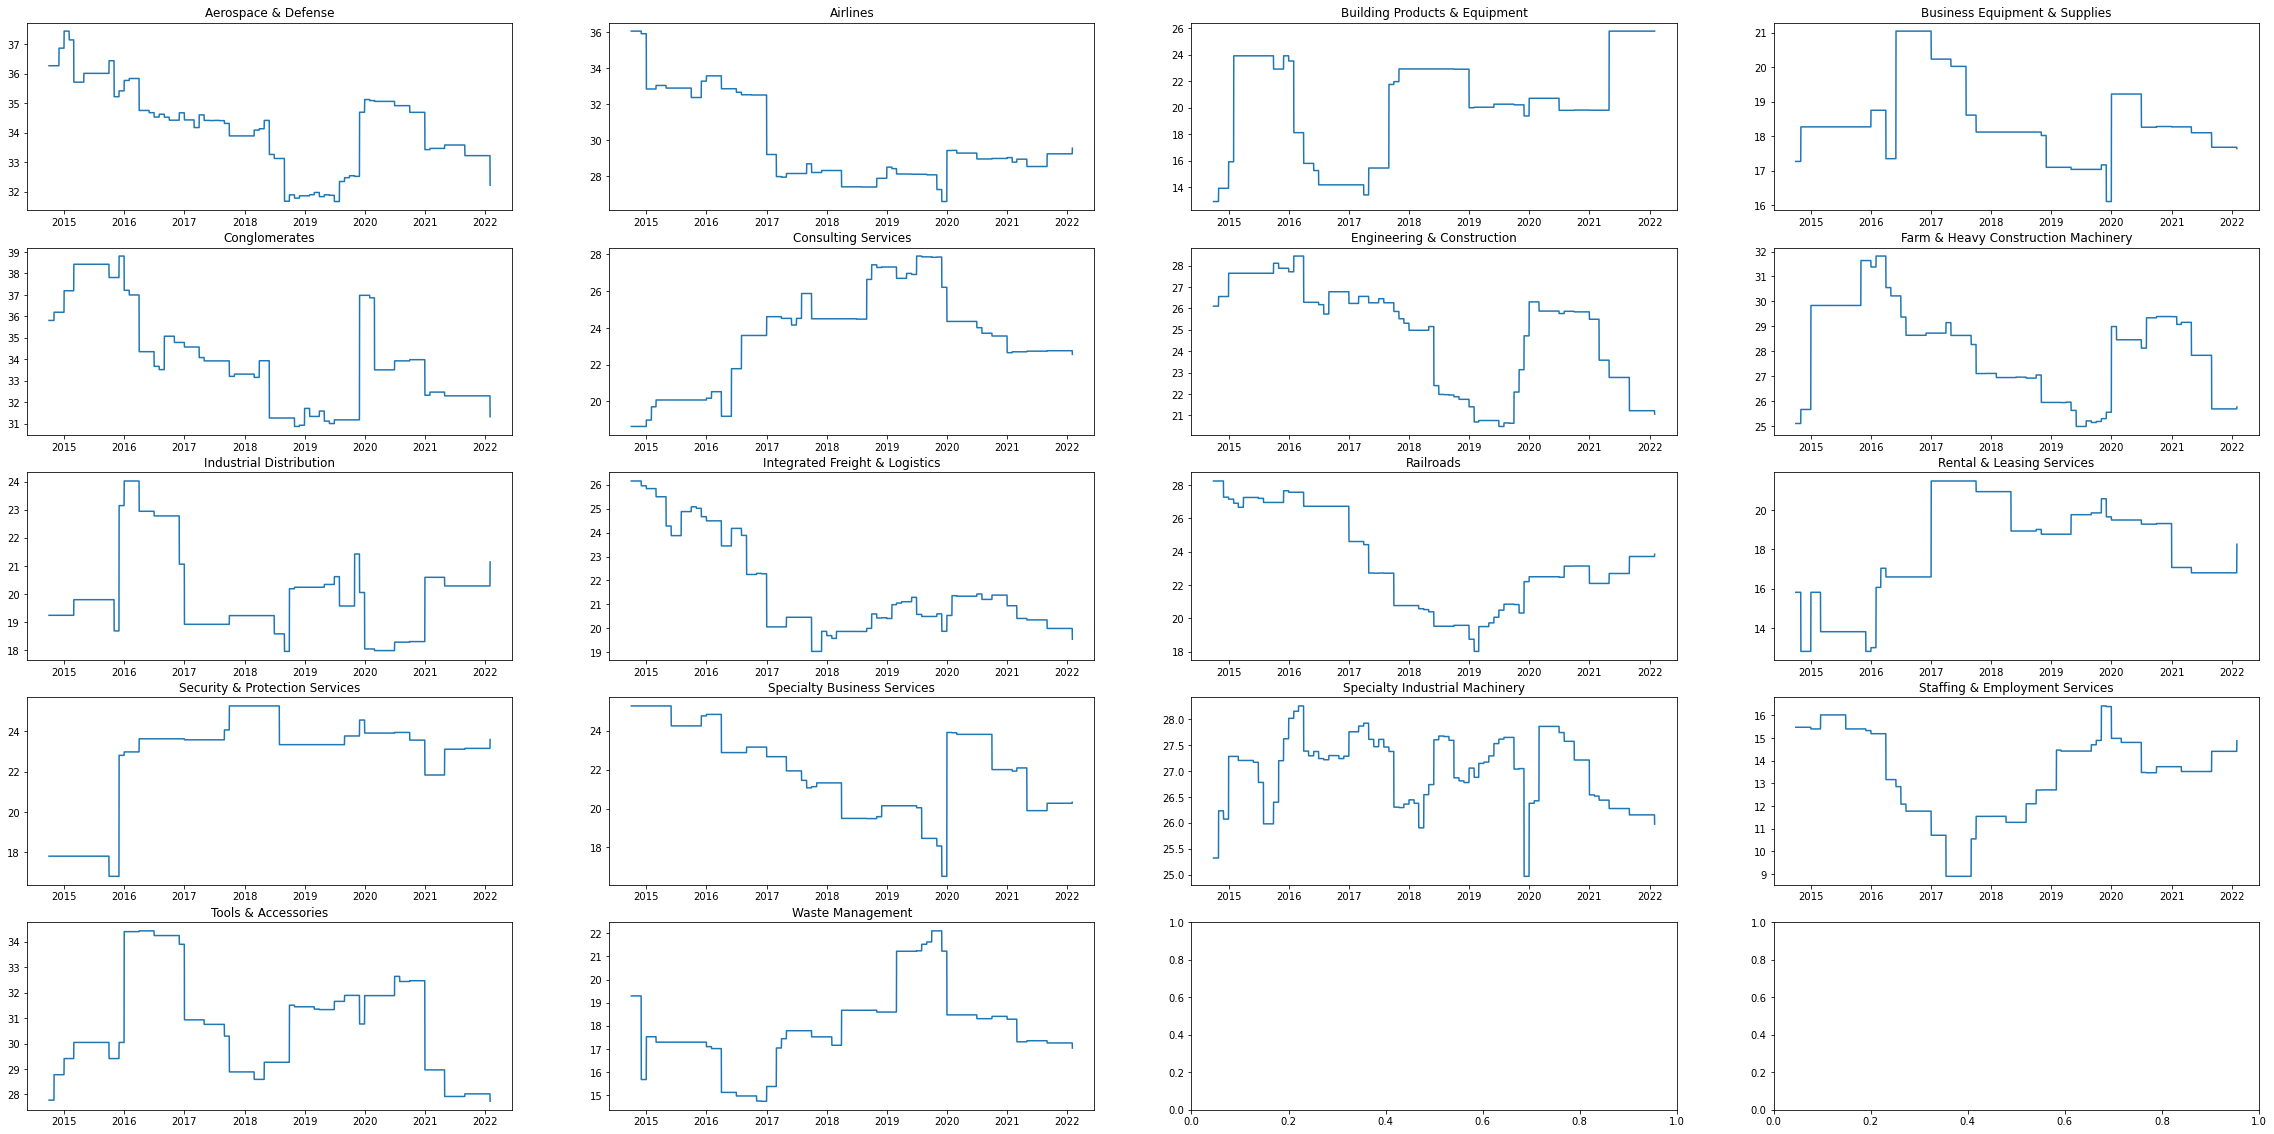

In [214]:
industrial_sector, all_observed = industry_index('Industrials', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)
        

    


In [216]:
industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/Industrial_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)



# Energy

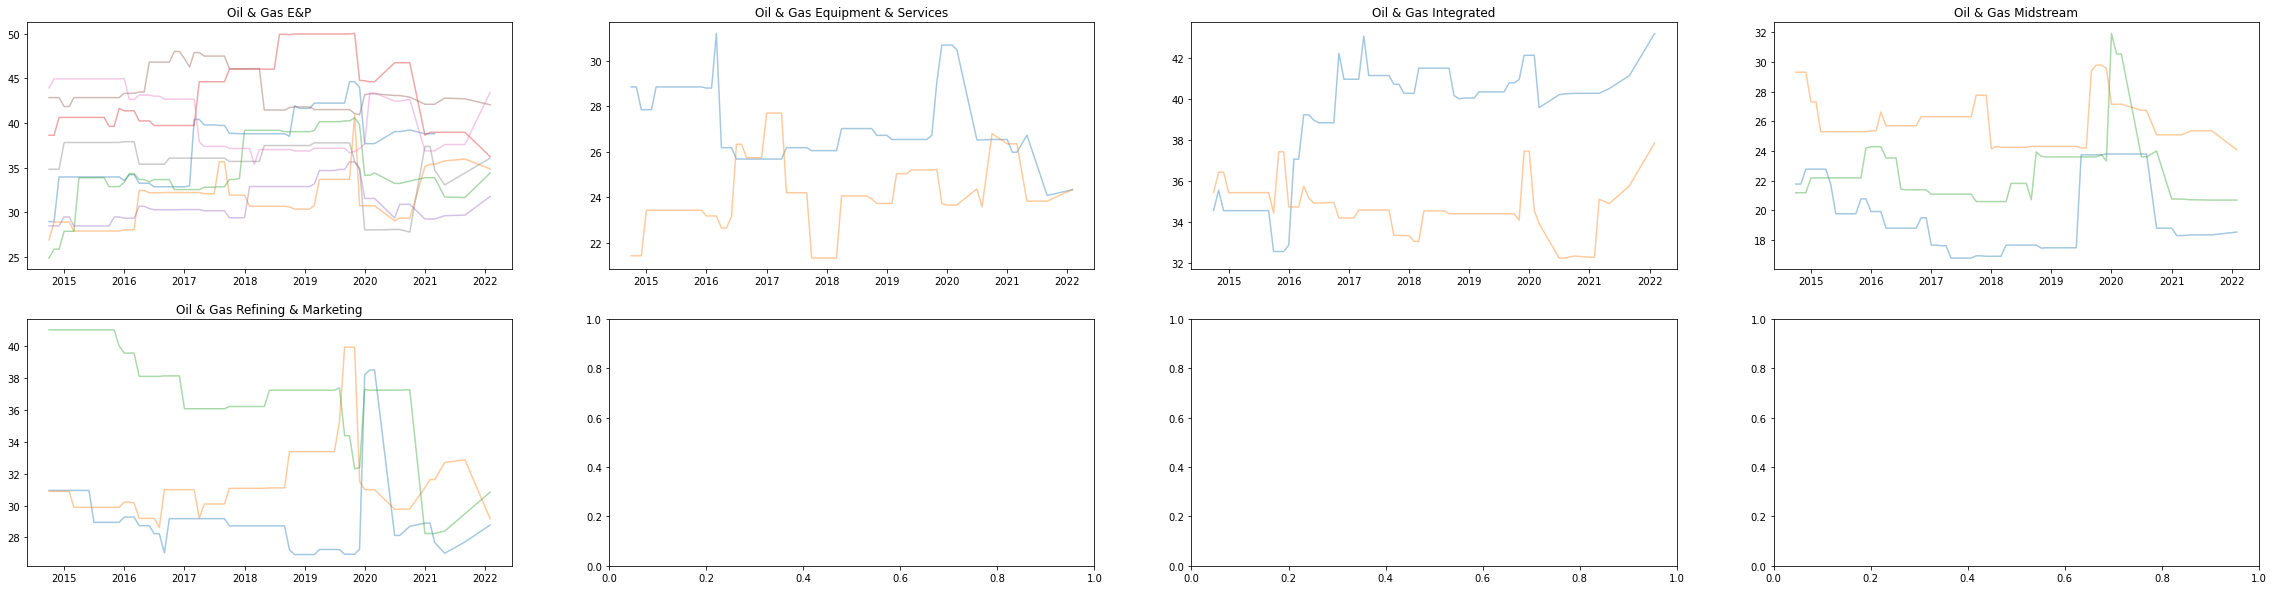

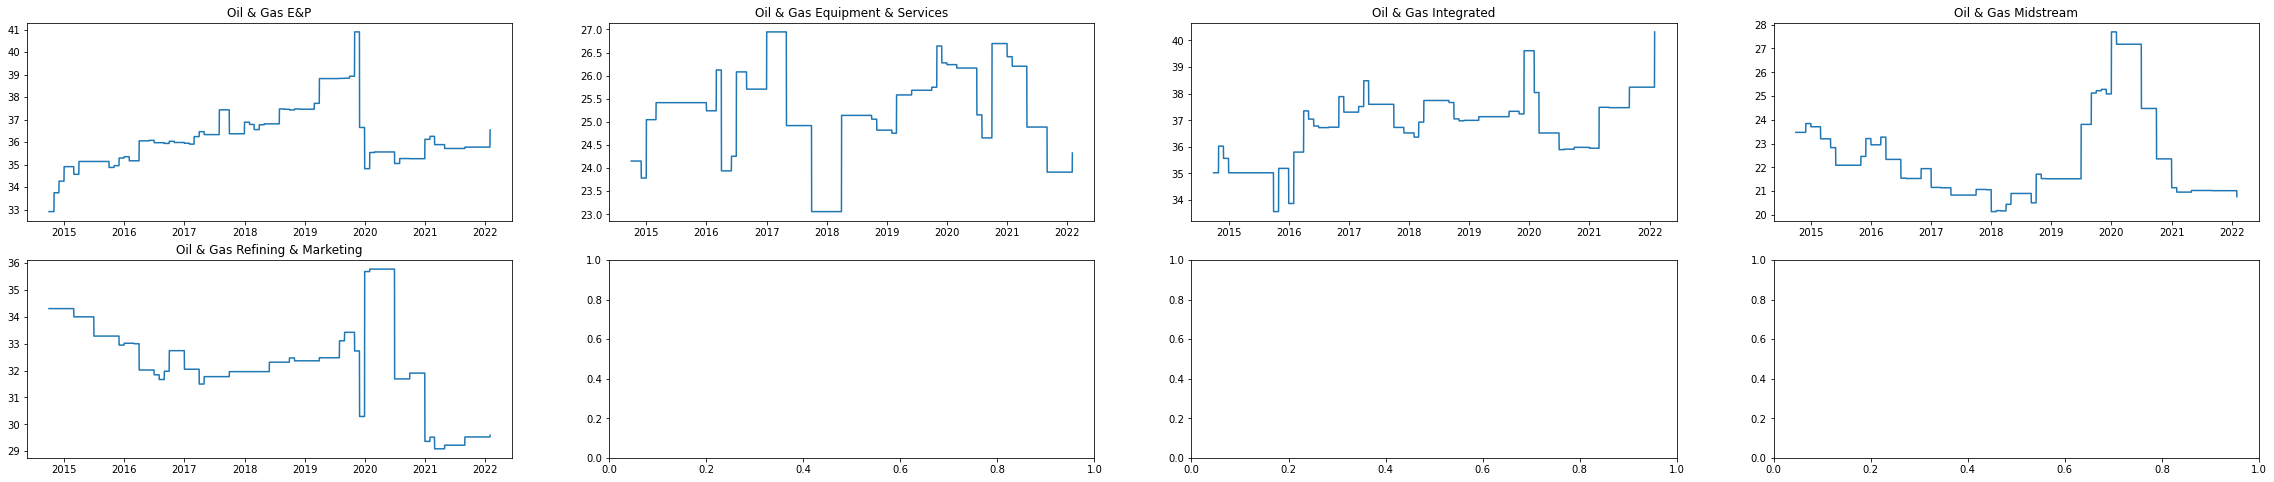

In [217]:
plot_esg_industry('Energy', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Energy', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/Energy_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)

        

# Utilities

No esg data on companies in industry Utilities—Renewable


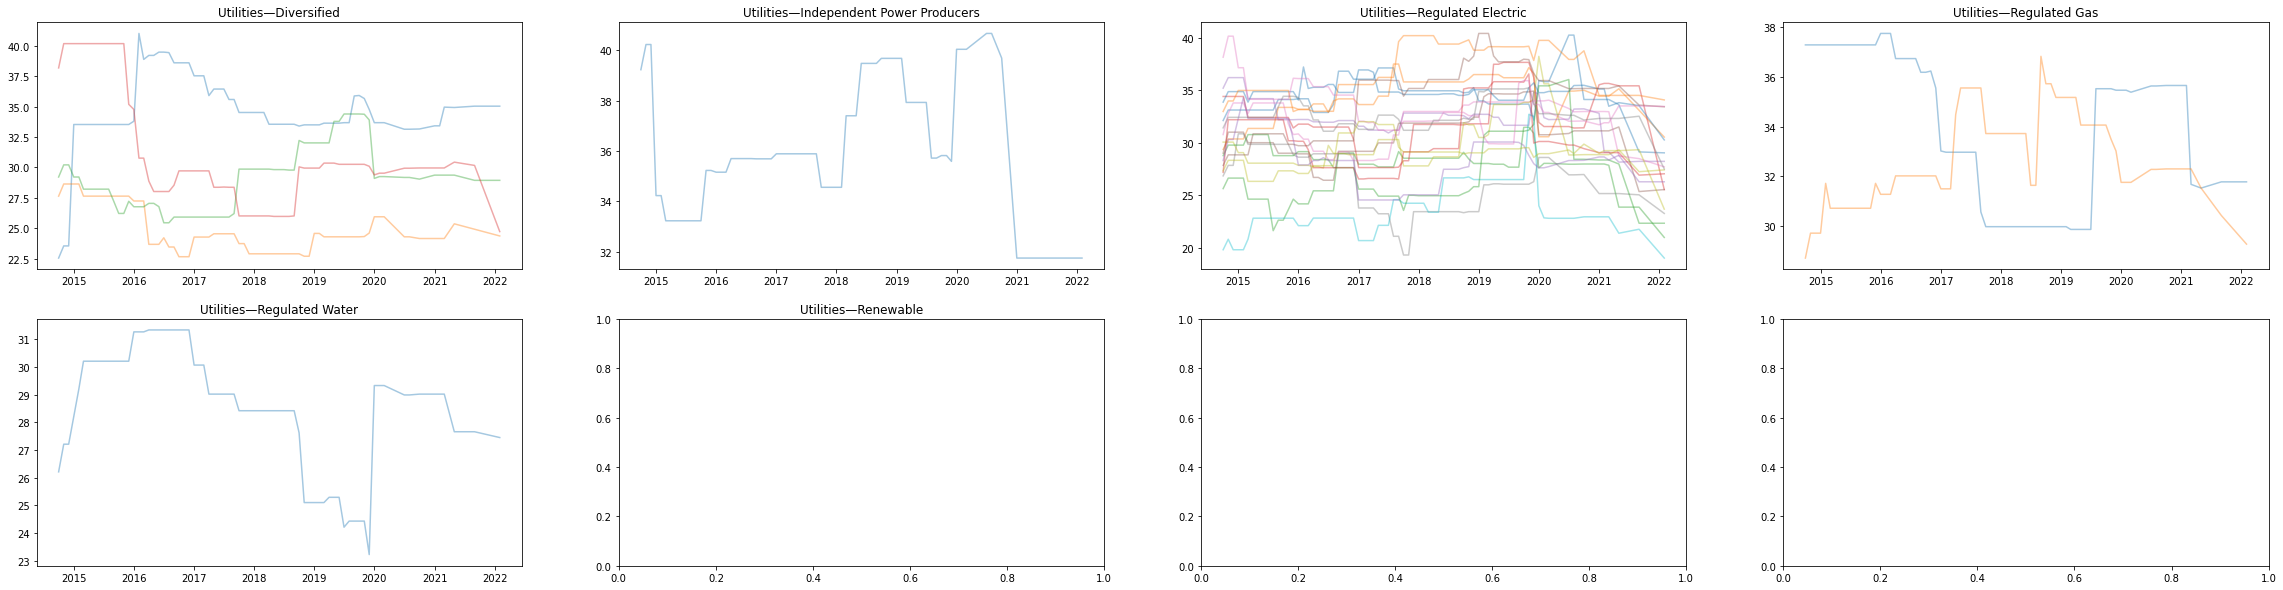

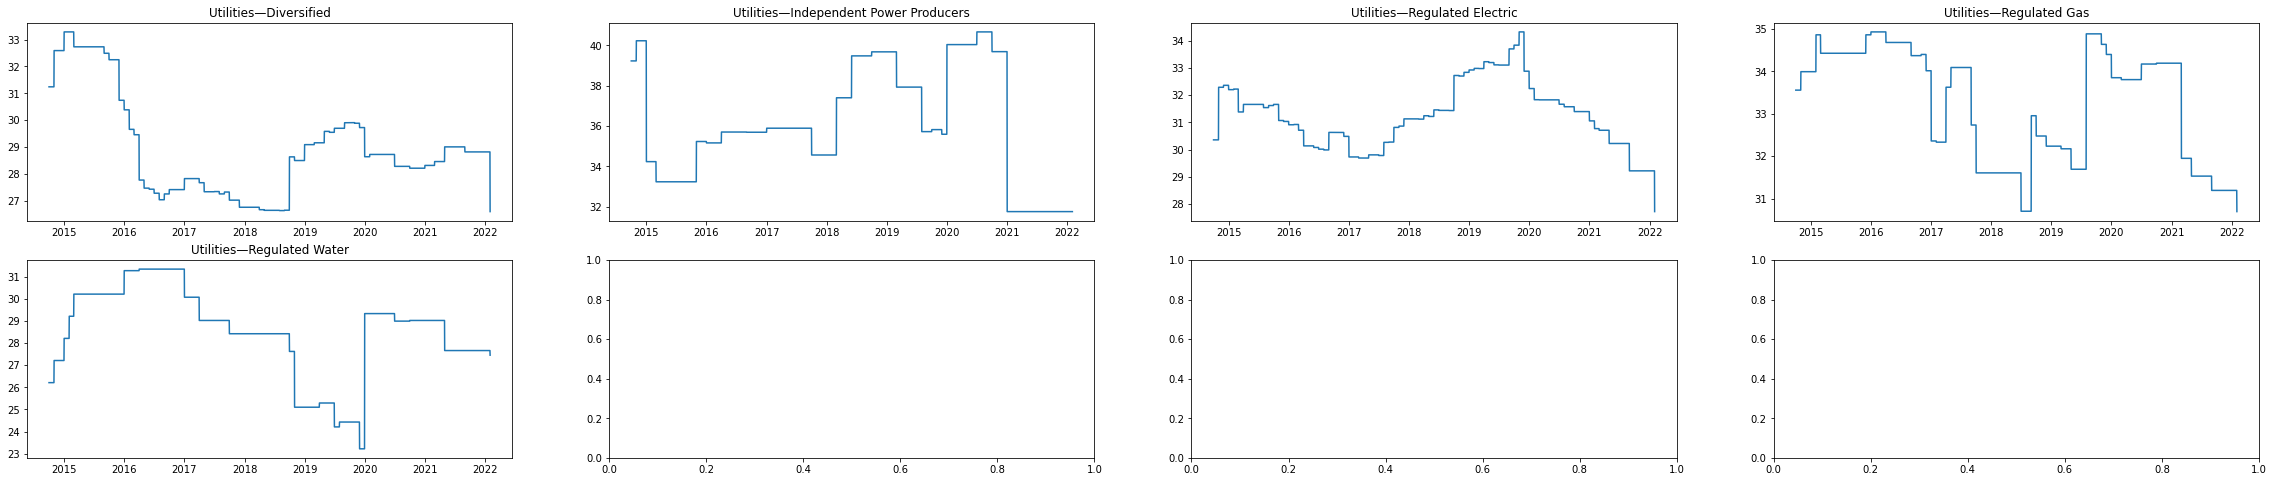

In [218]:
plot_esg_industry('Utilities', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Utilities', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/Utilities_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)

        

# Basic Materials

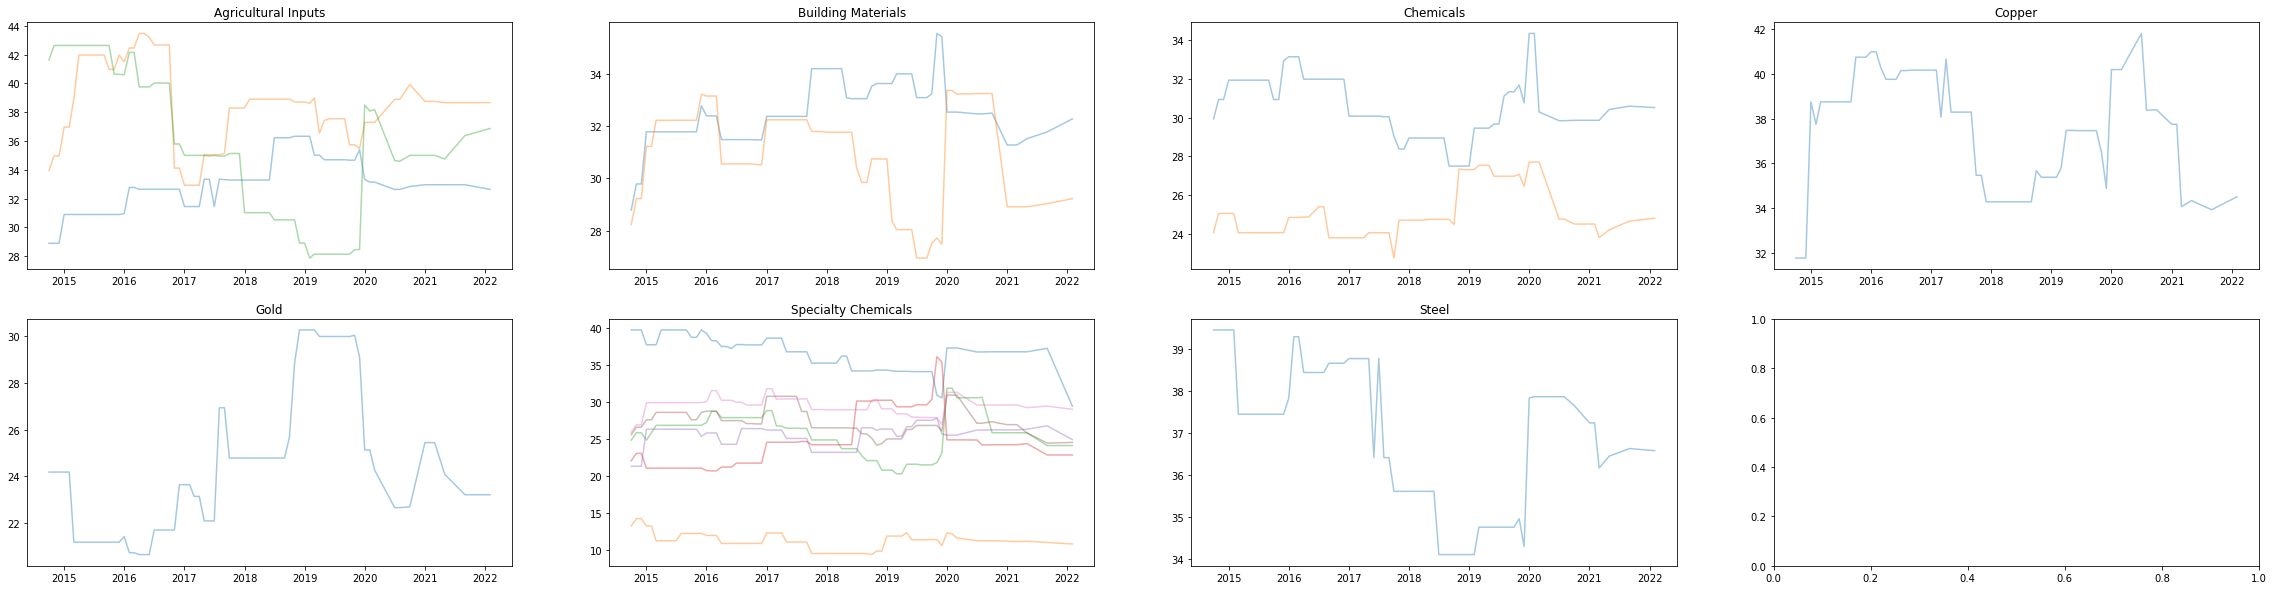

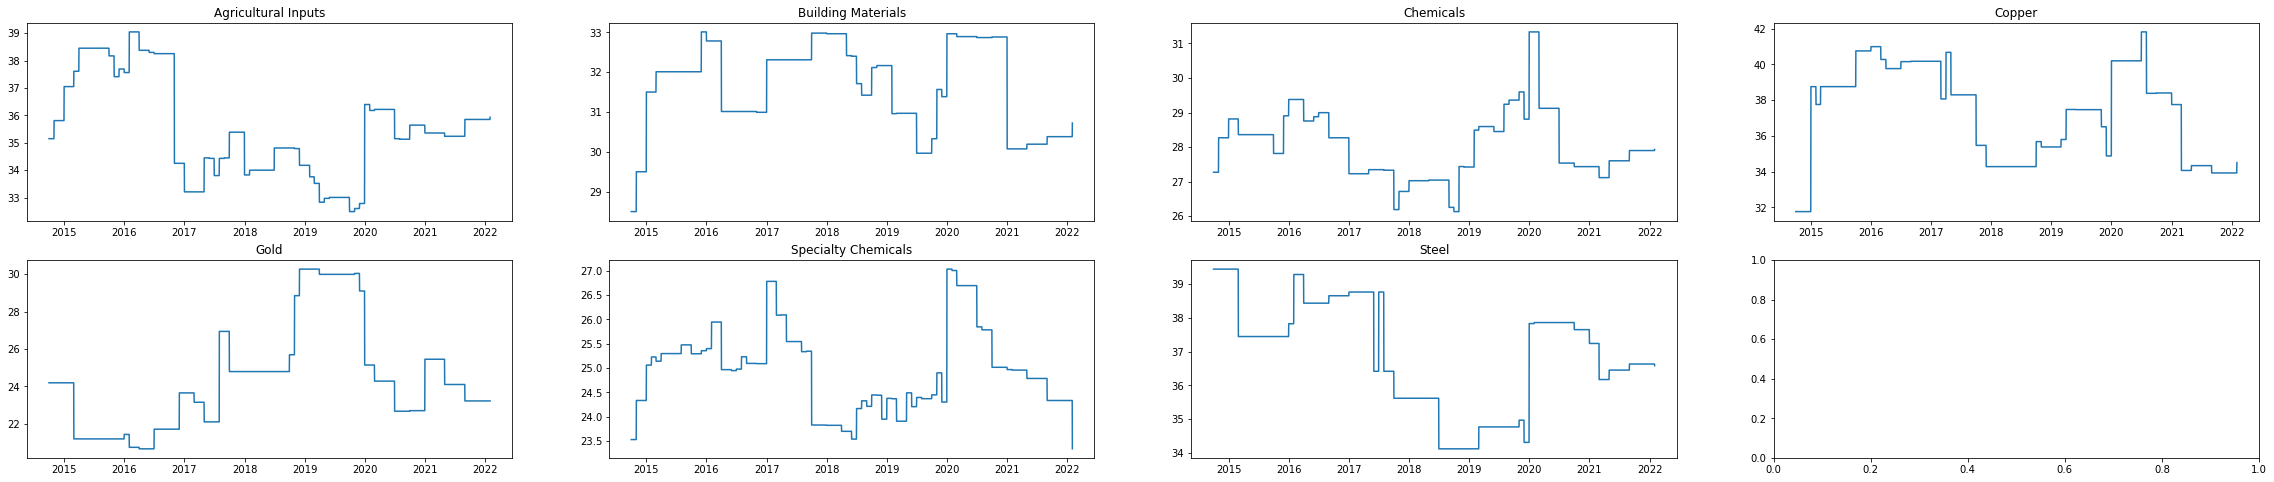

In [219]:
plot_esg_industry('Basic Materials', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Basic Materials', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)


industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/BasicMaterials_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)


# Financial Services

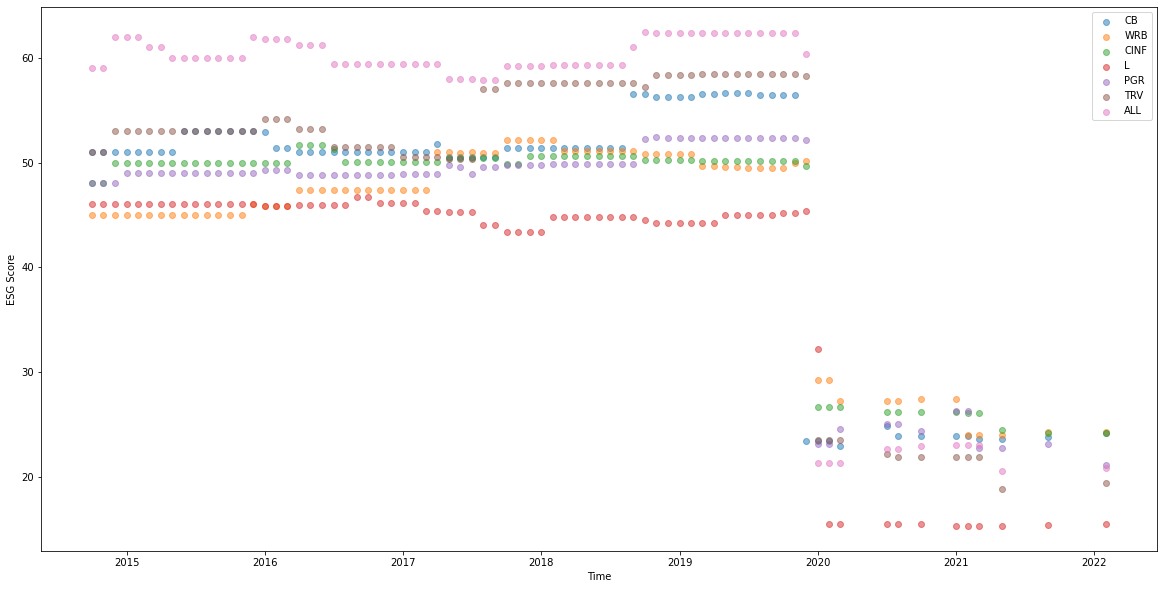

In [103]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

for i, stock in enumerate(['CB', 'WRB', 'CINF', 'L', 'PGR', 'TRV', 'ALL']):
    ax.scatter(esg_pivot_shifted.index, esg_pivot[stock], alpha = 0.5, label = stock)
    ax.set_ylabel("ESG Score")
    ax.set_xlabel("Time")

ax.legend()

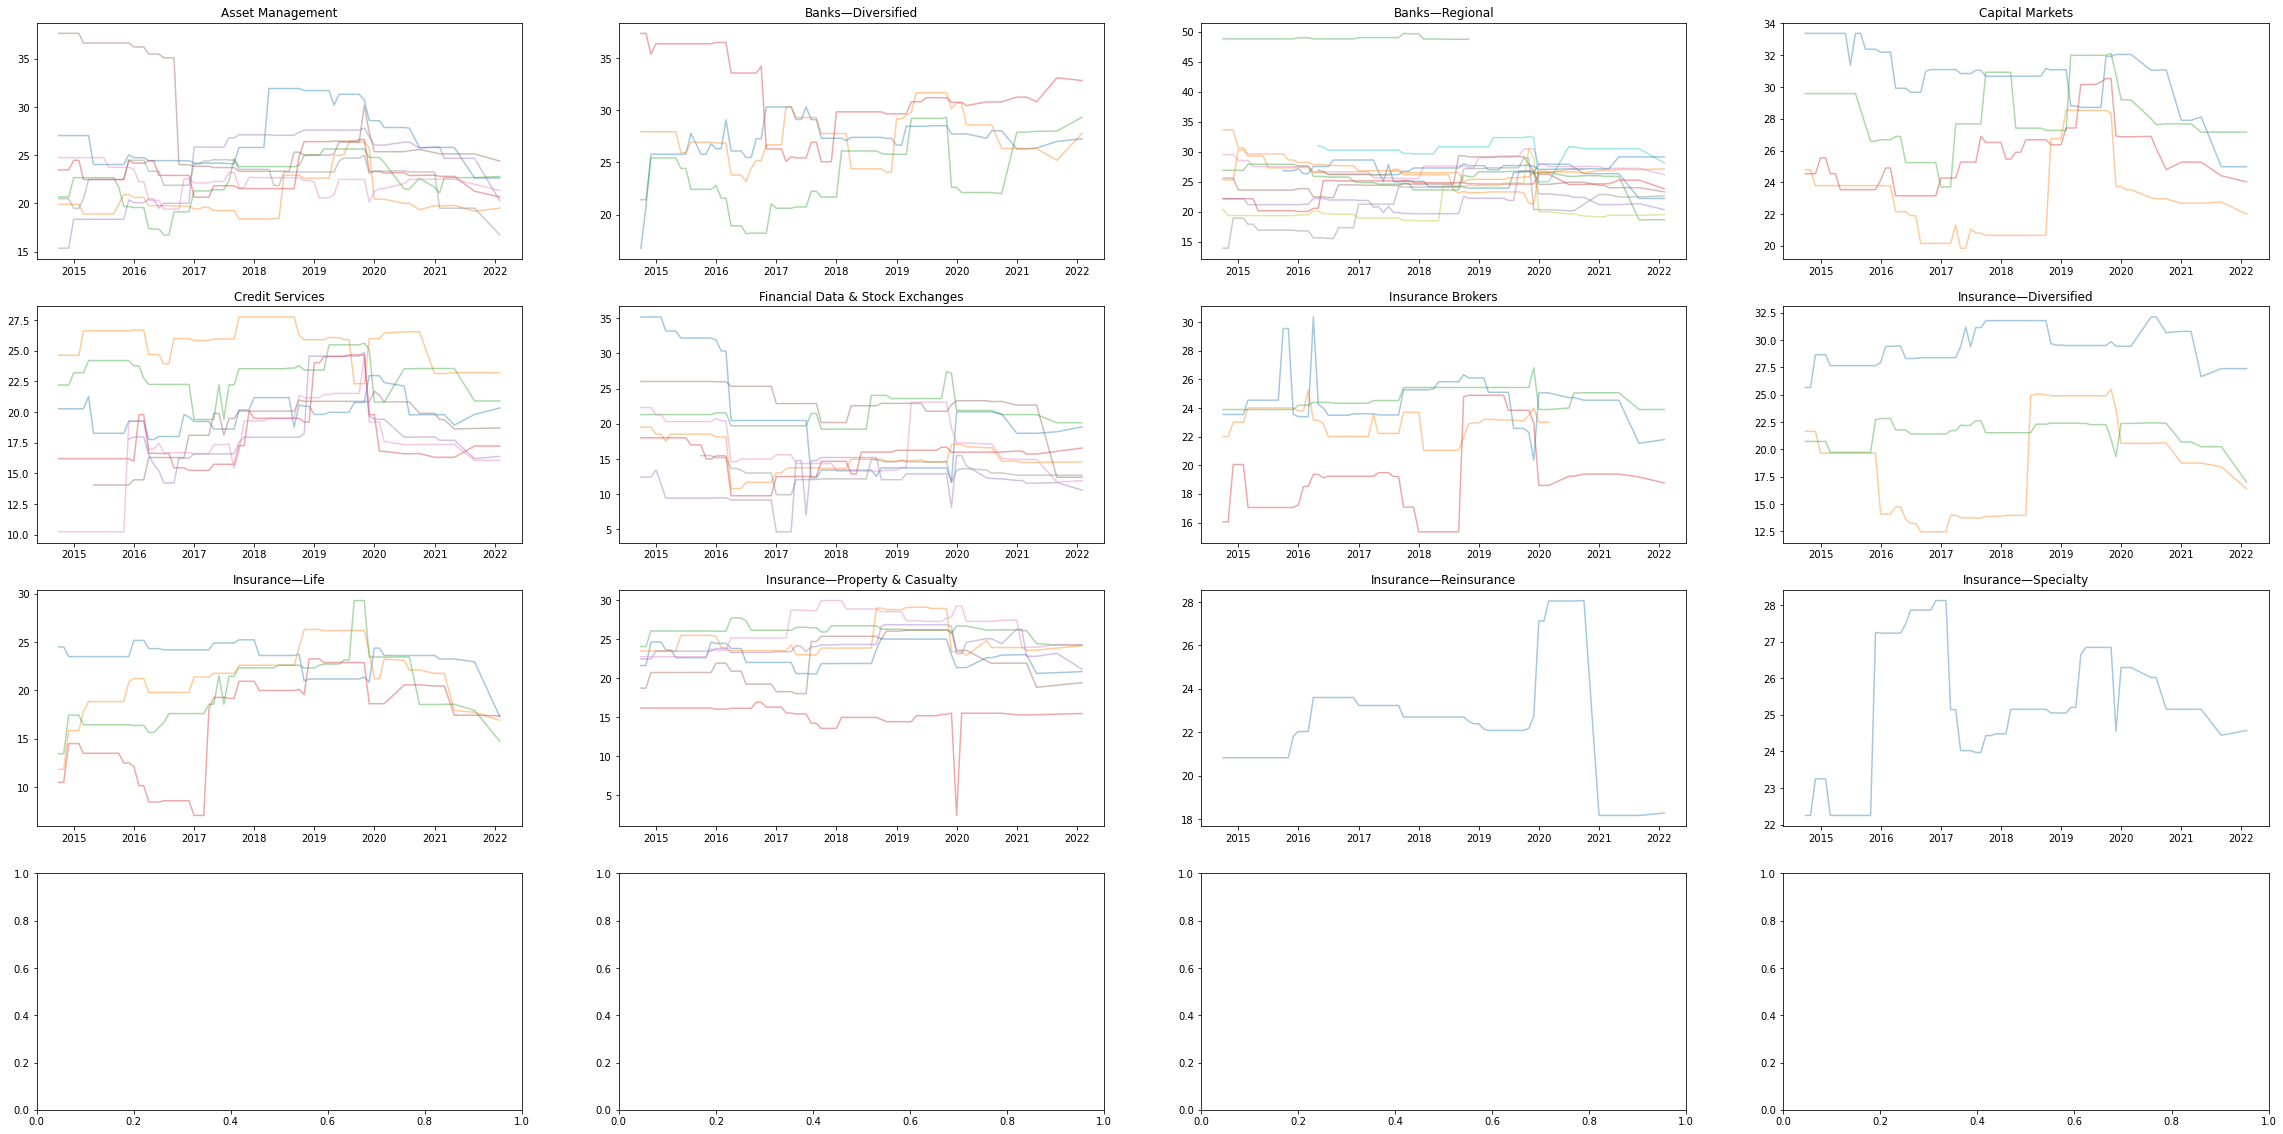

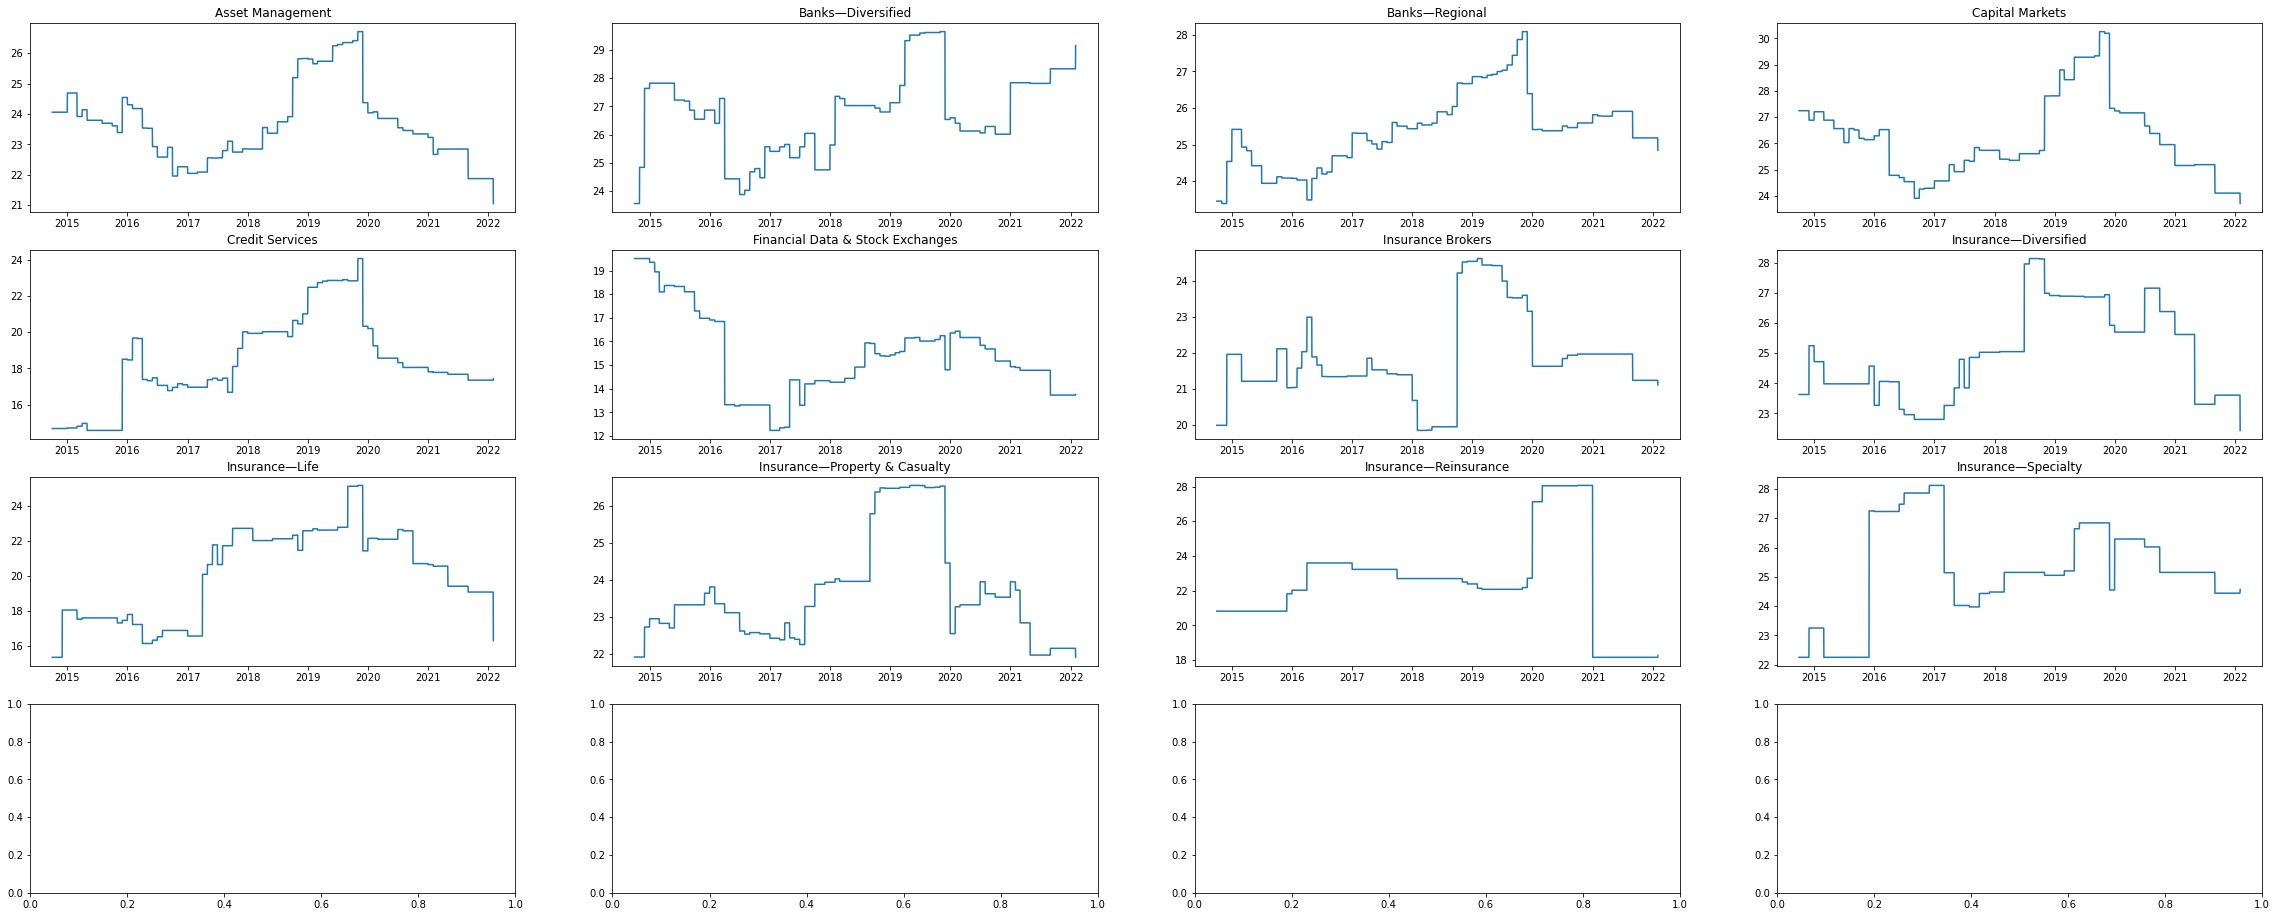

In [221]:
plot_esg_industry('Financial Services', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Financial Services', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/FinancialServices_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)



# Consumer Defensive

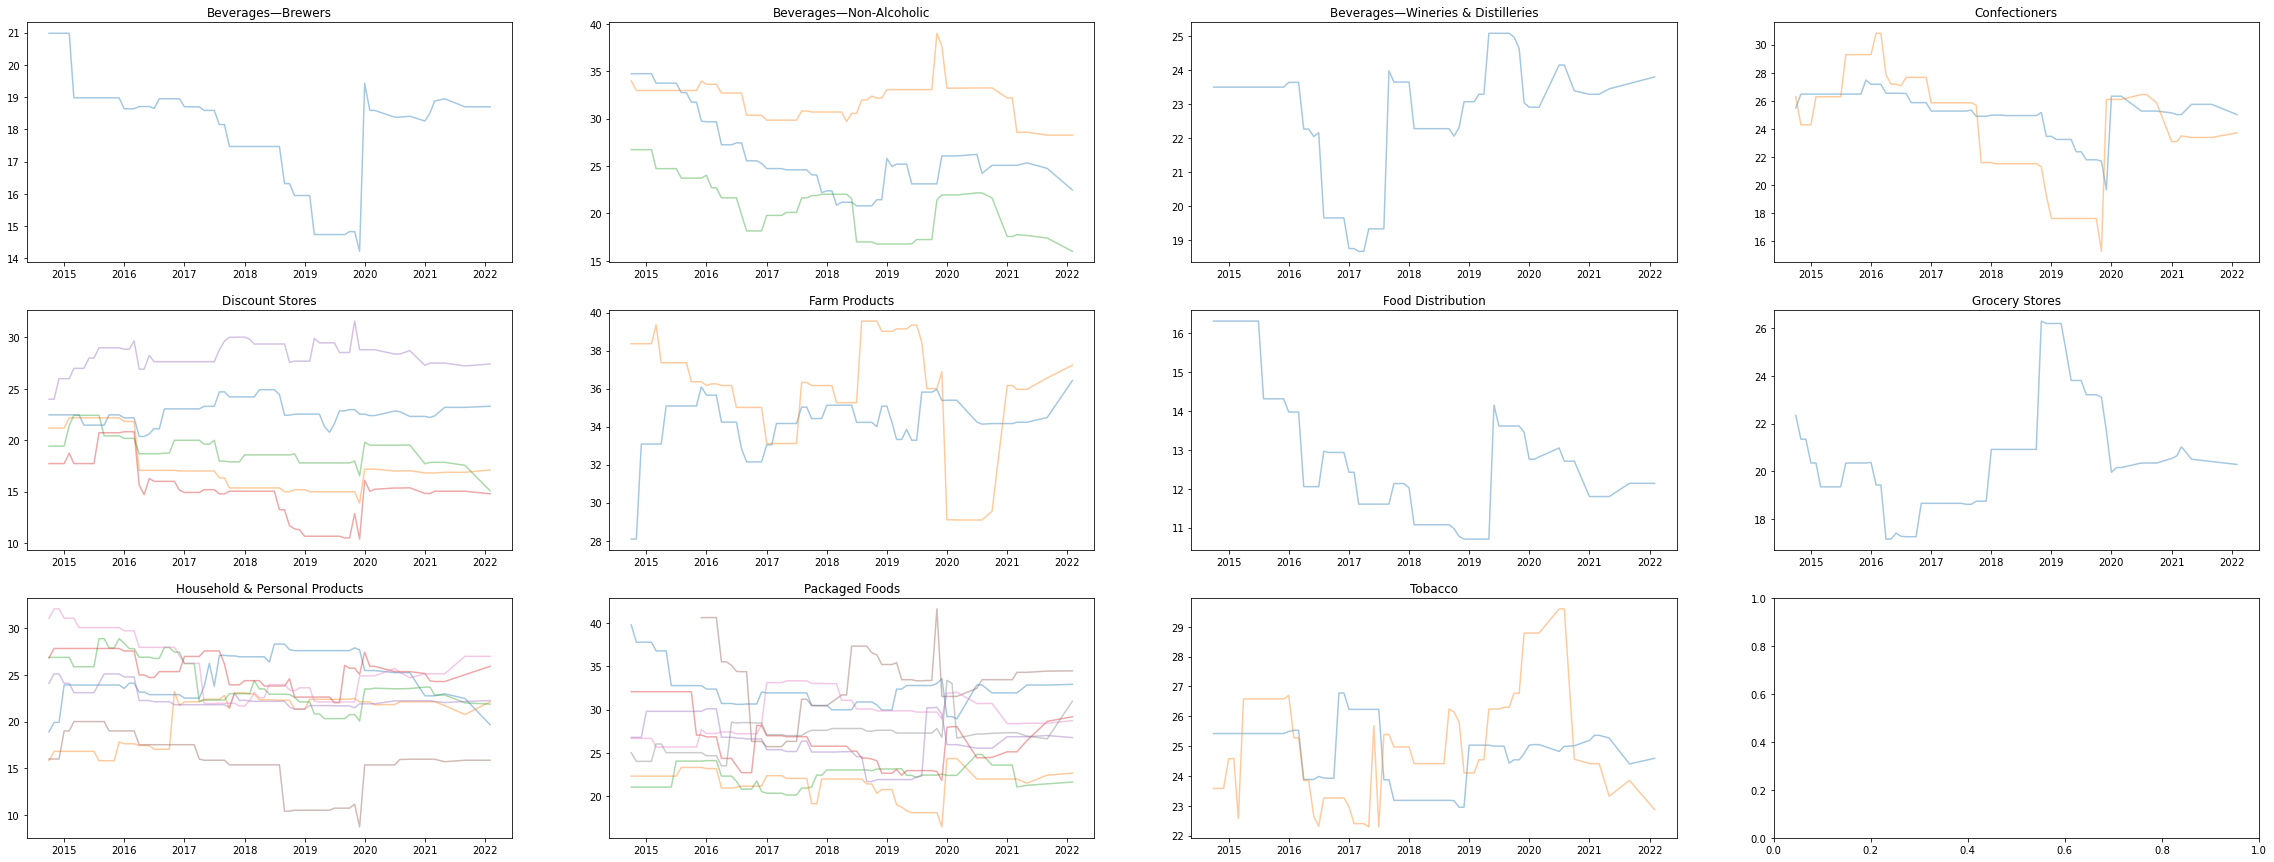

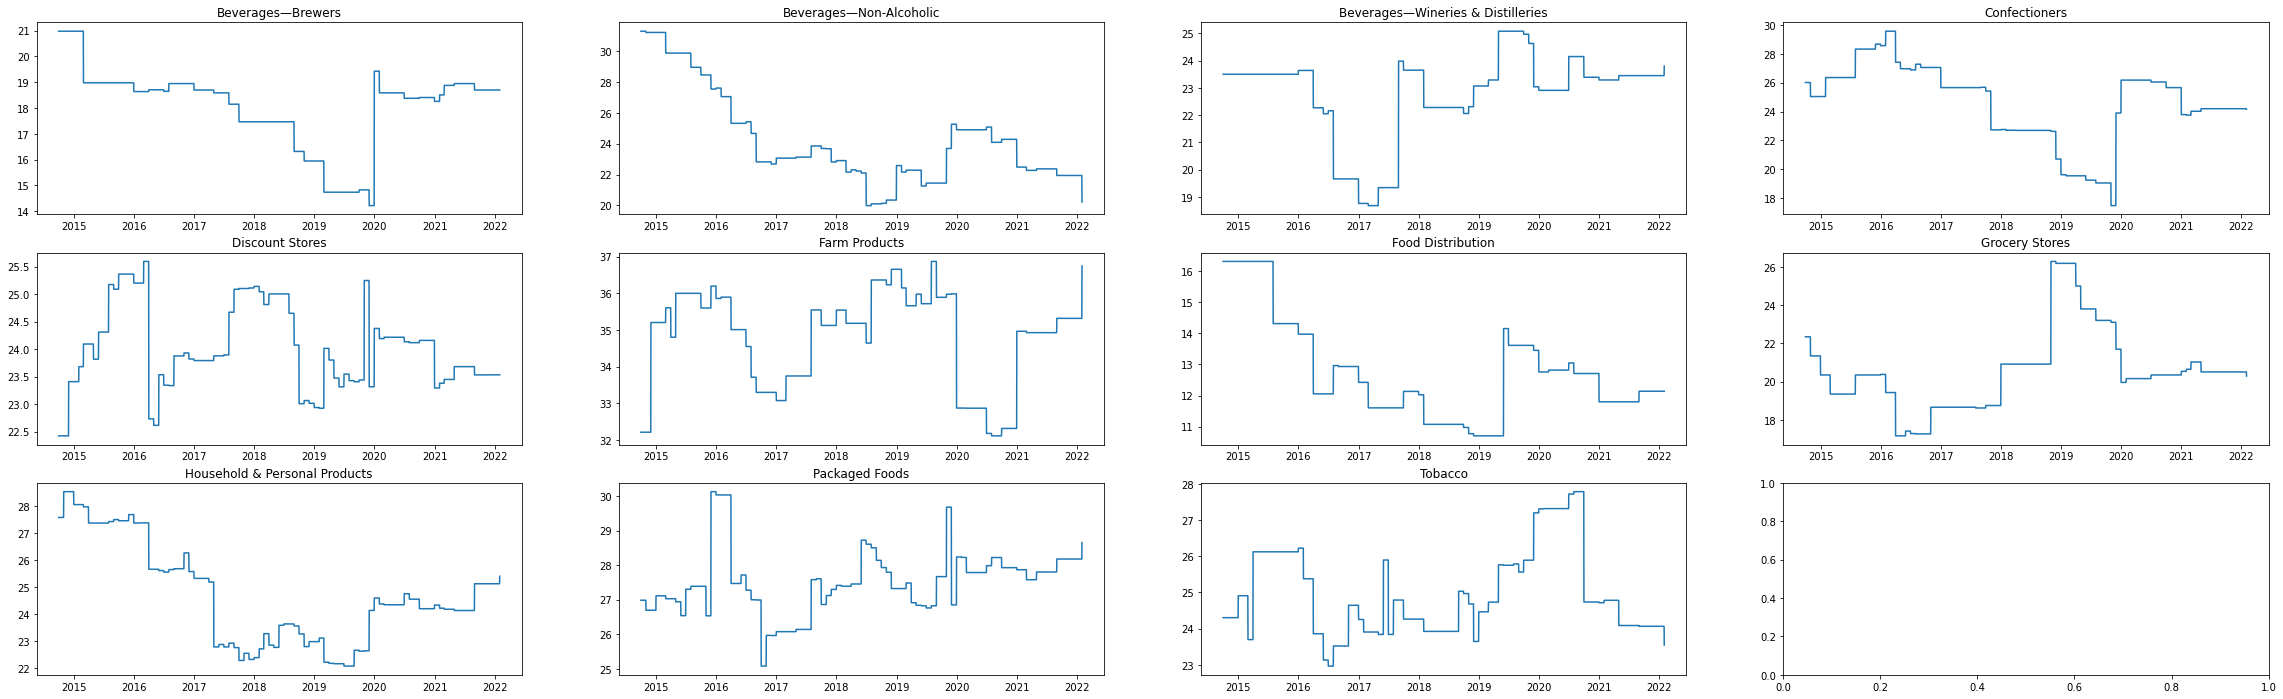

In [224]:
plot_esg_industry('Consumer Defensive', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Consumer Defensive', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/ConsumerDefensive_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)


# Consumer Cyclical

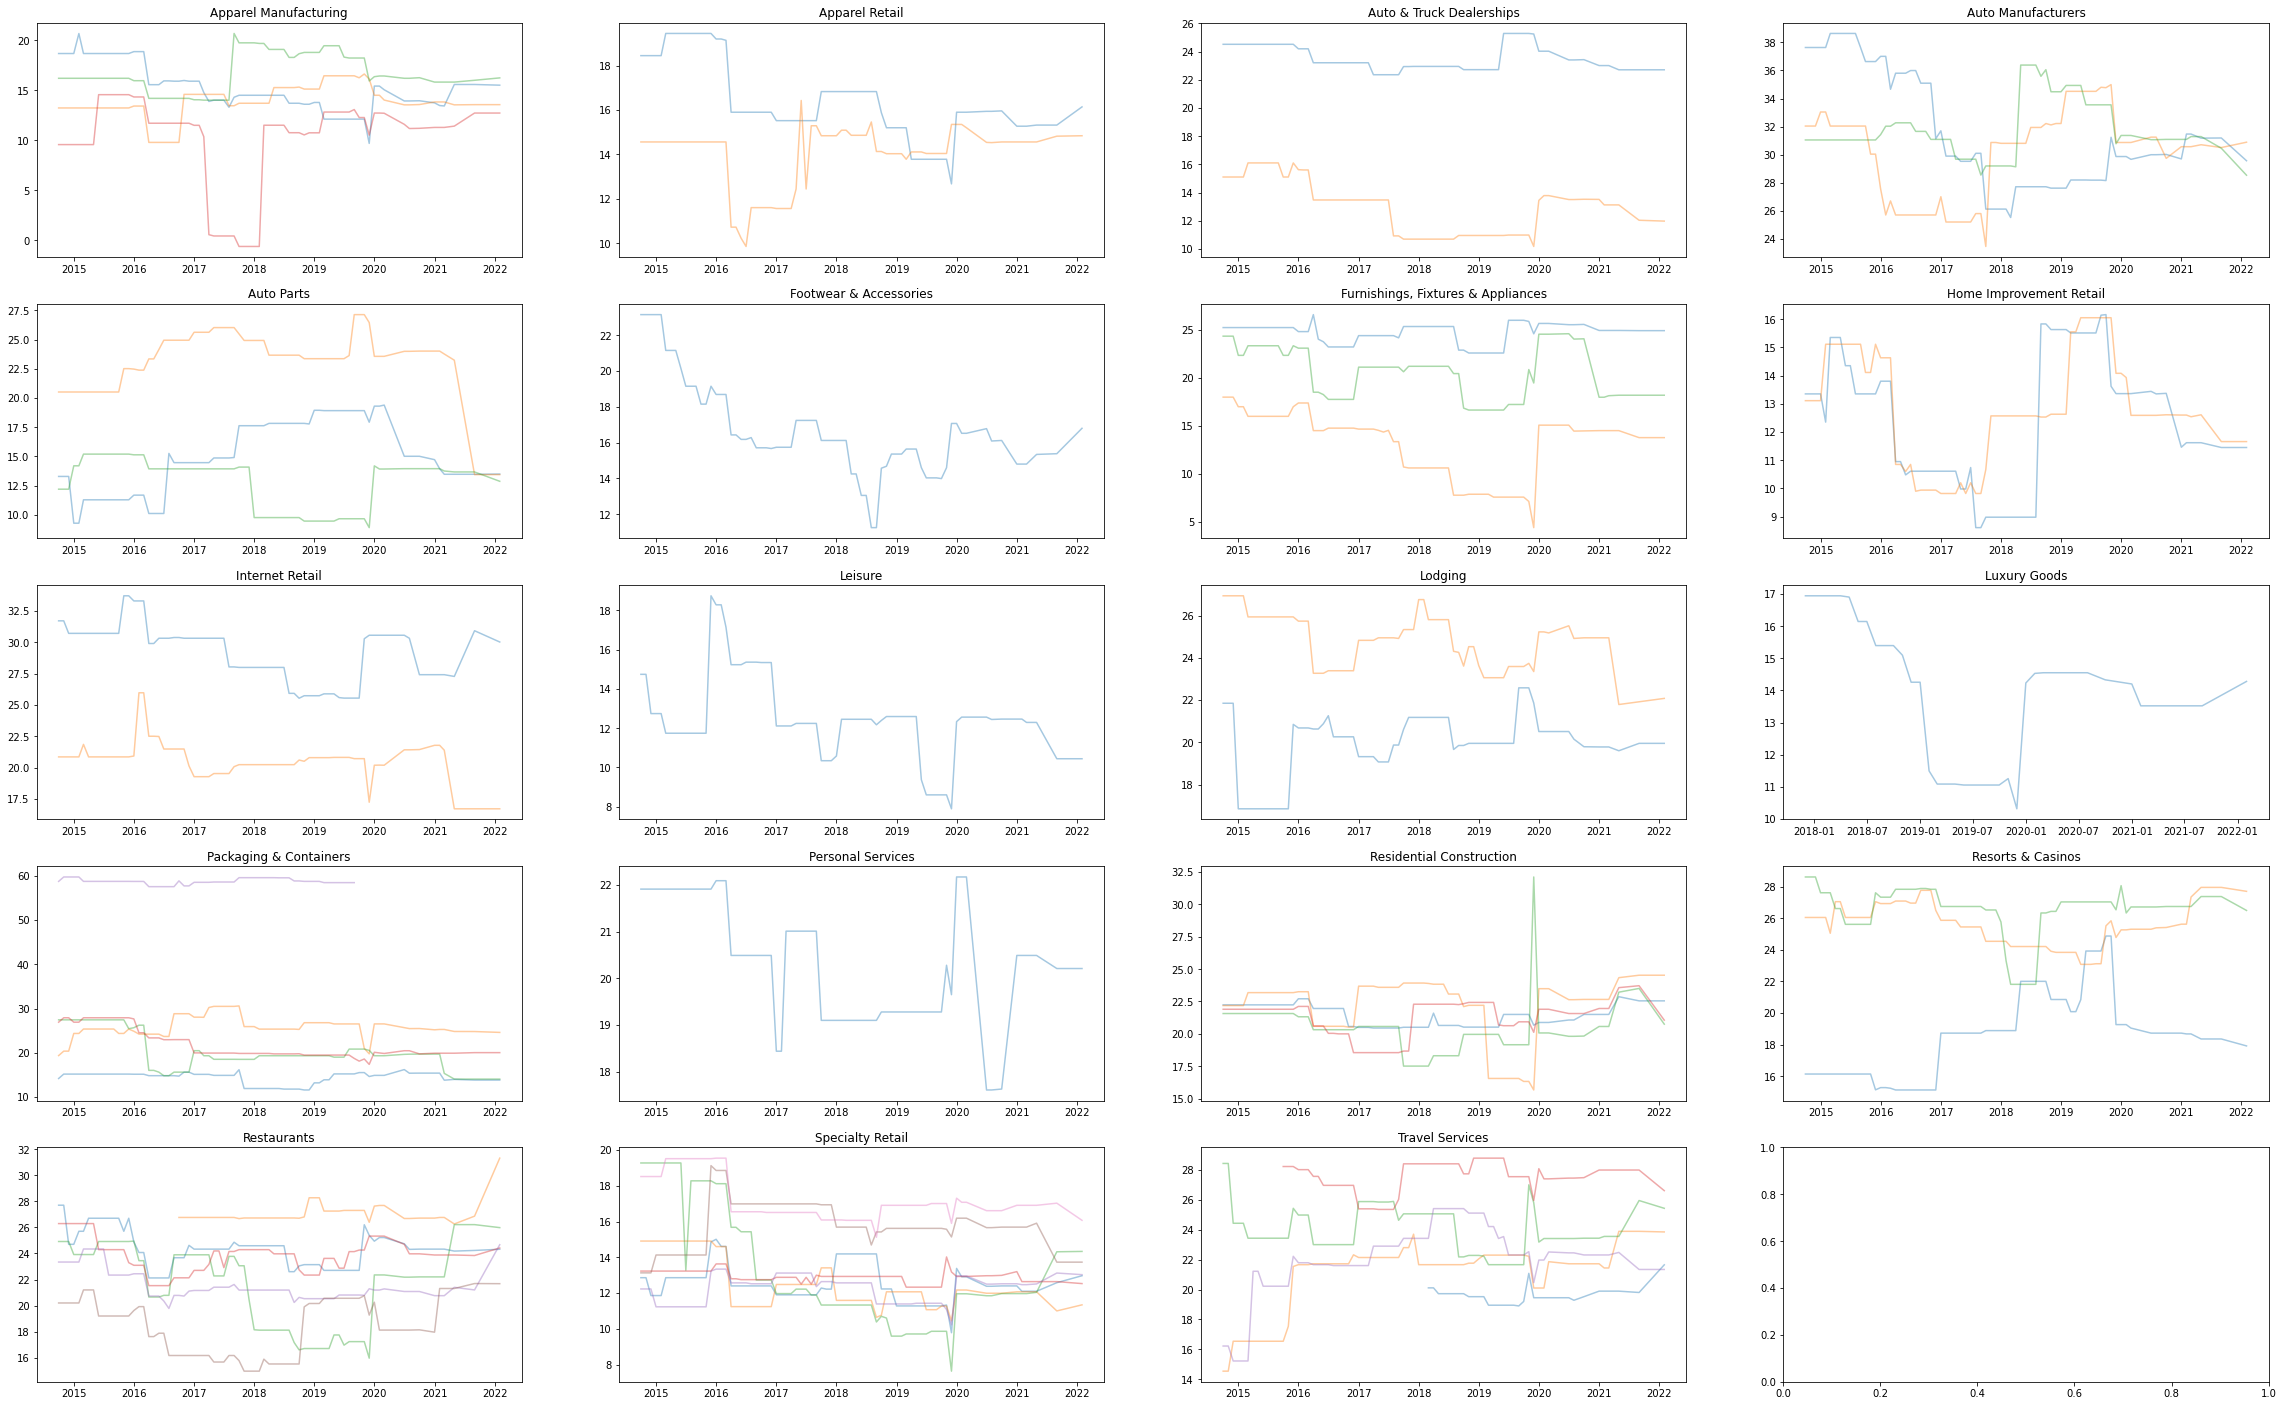

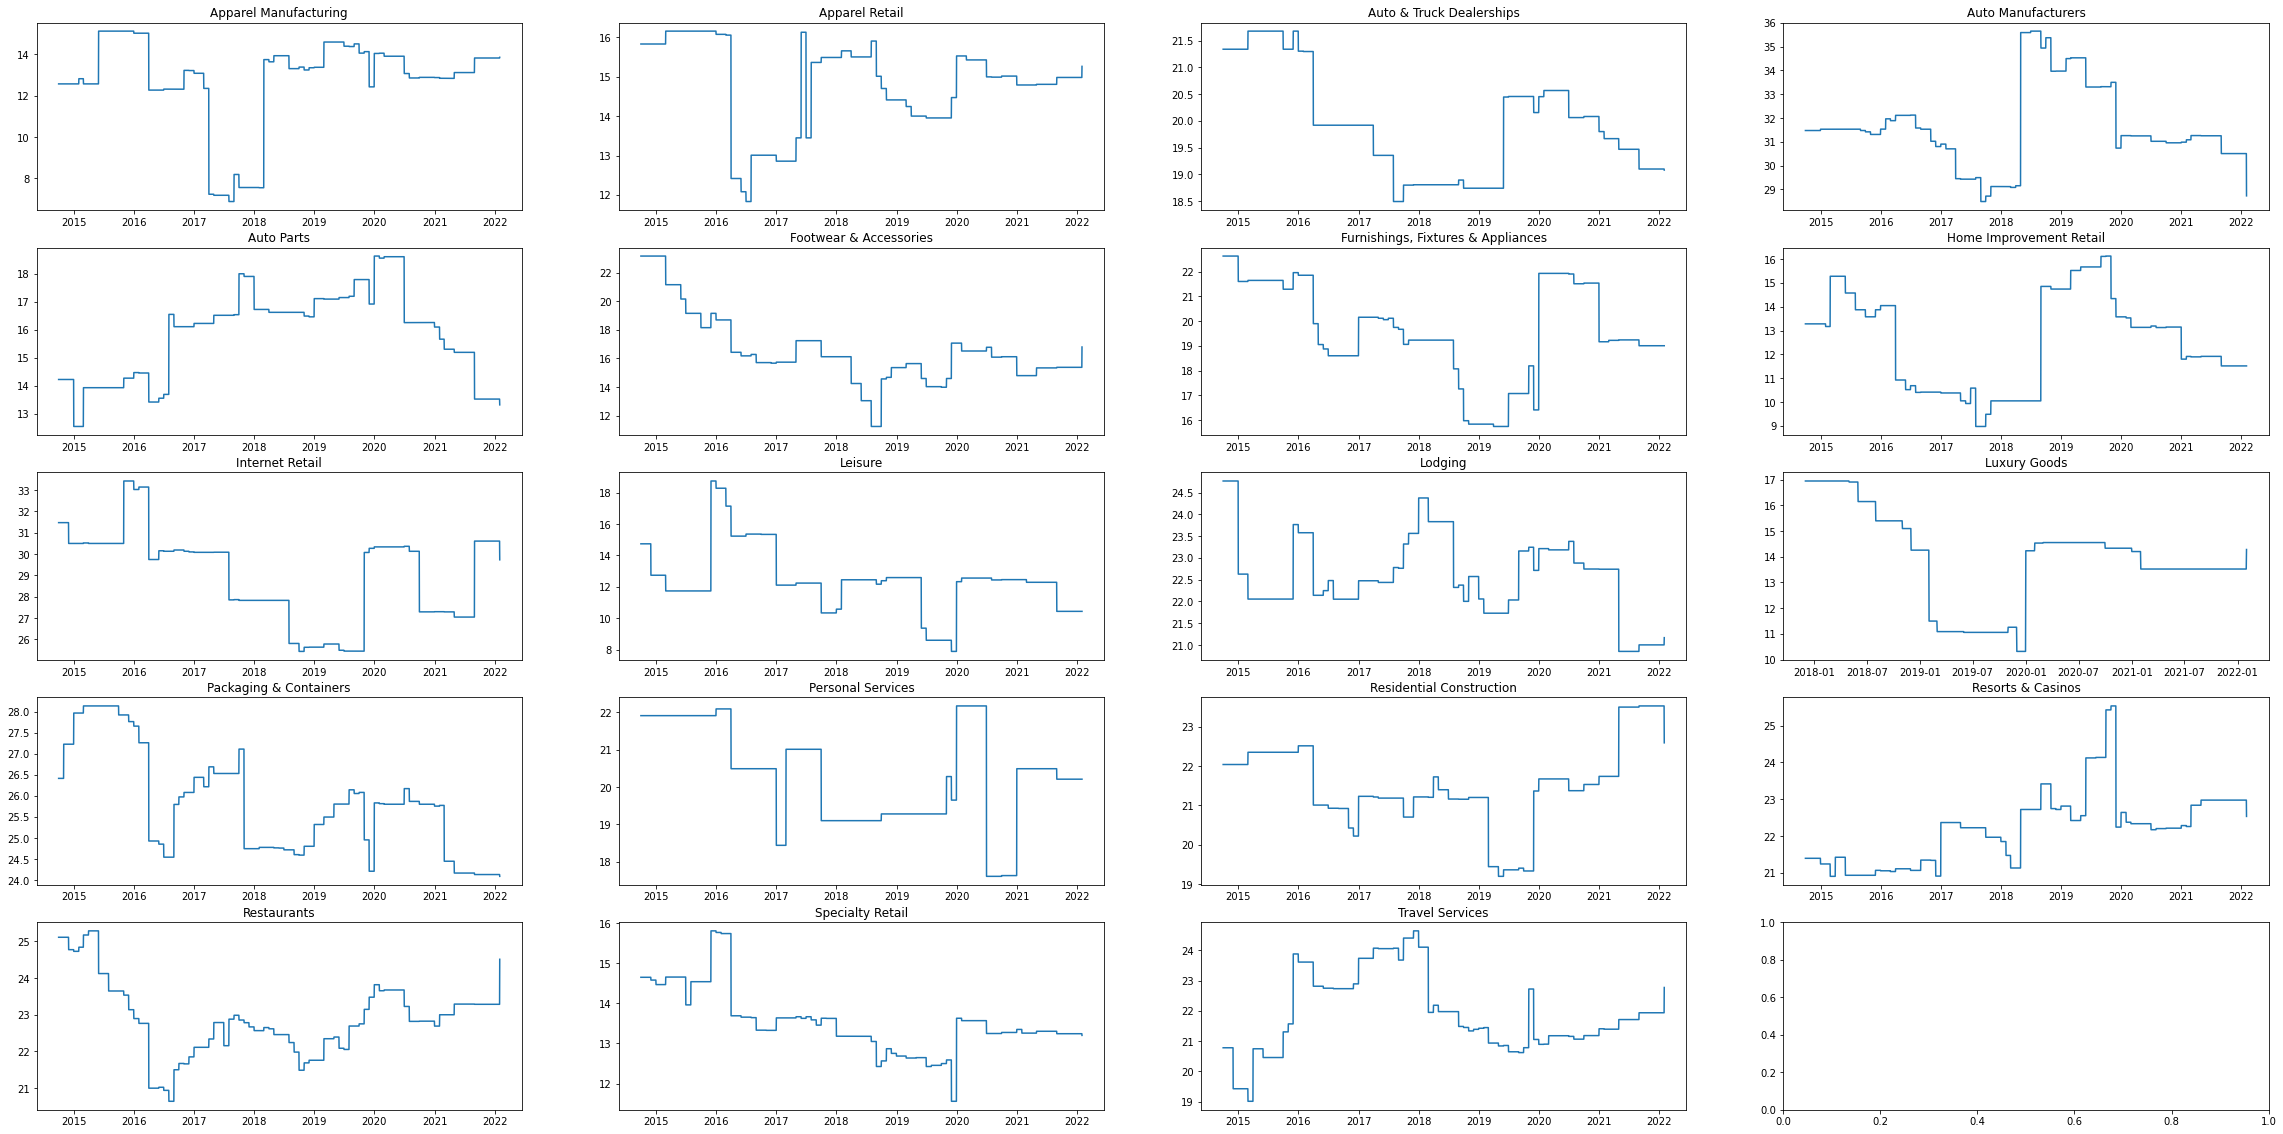

In [223]:
plot_esg_industry('Consumer Cyclical', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Consumer Cyclical', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/ConsumerCyclical_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)


# Technology

No esg data on companies in industry Solar
No esg data on companies in industry Solar


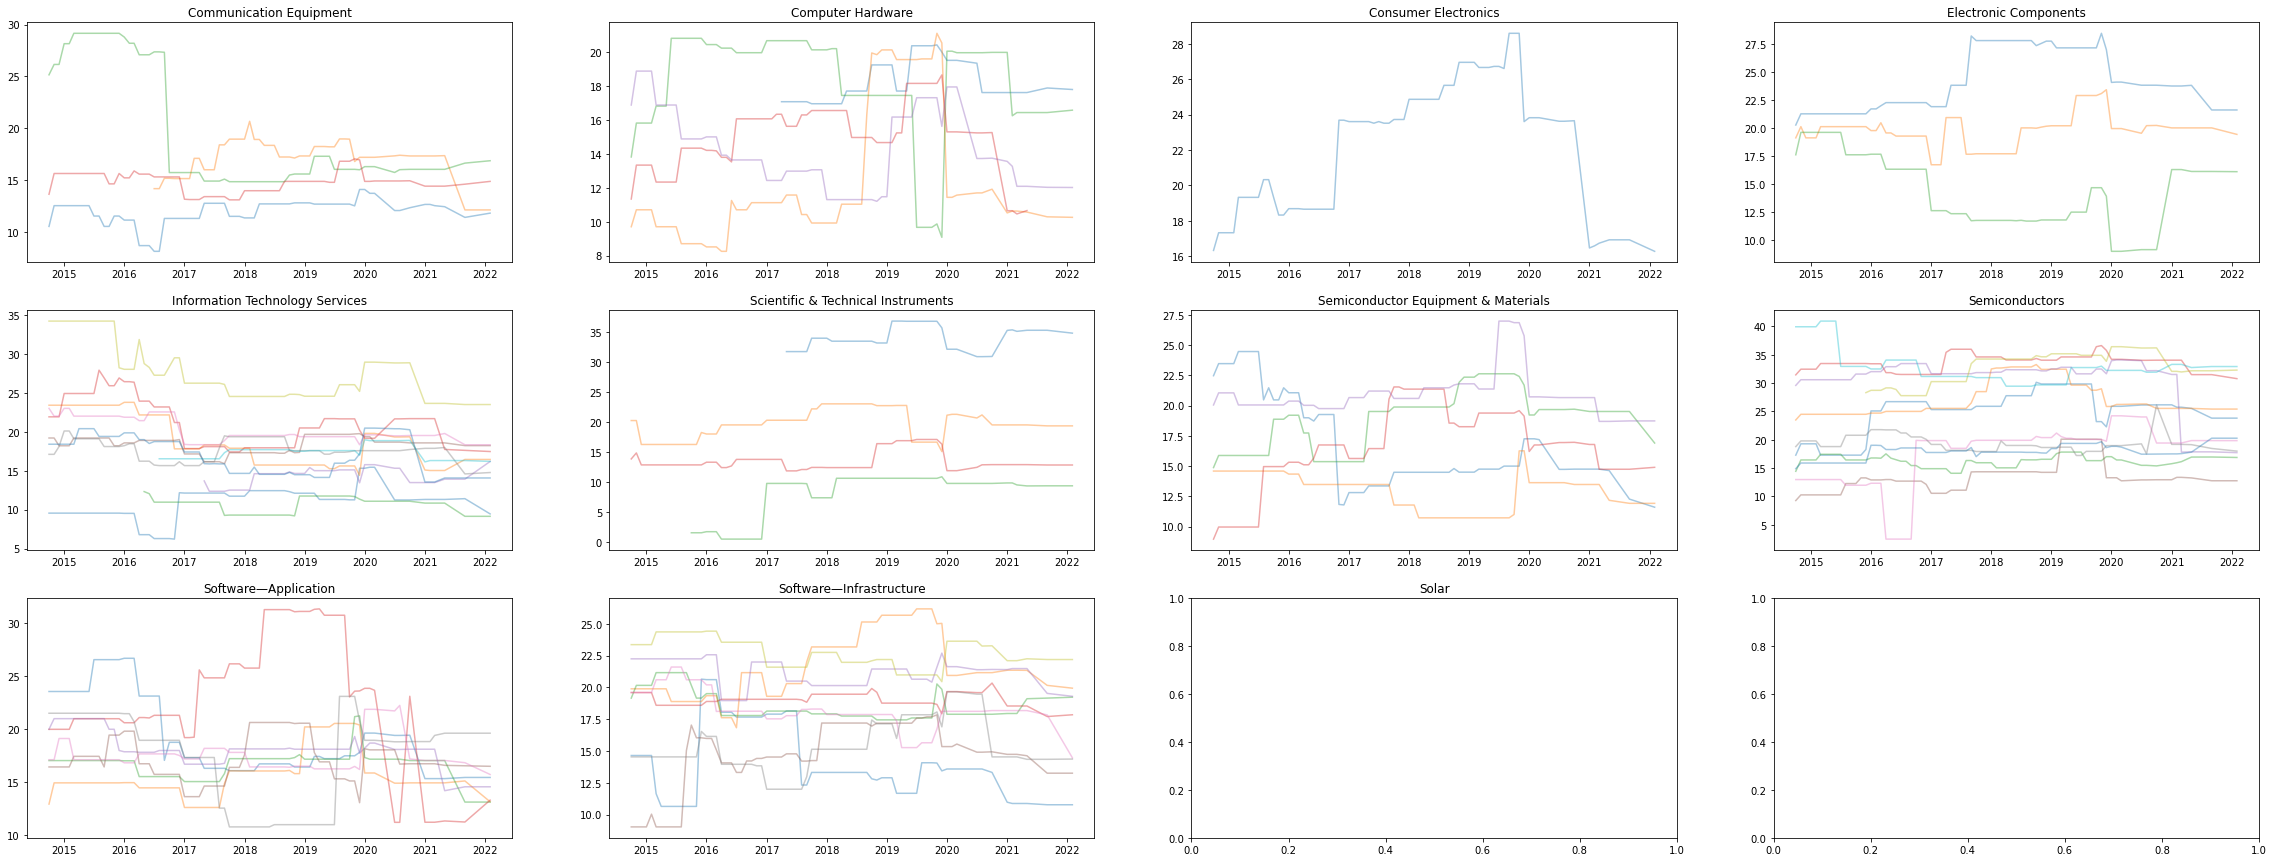

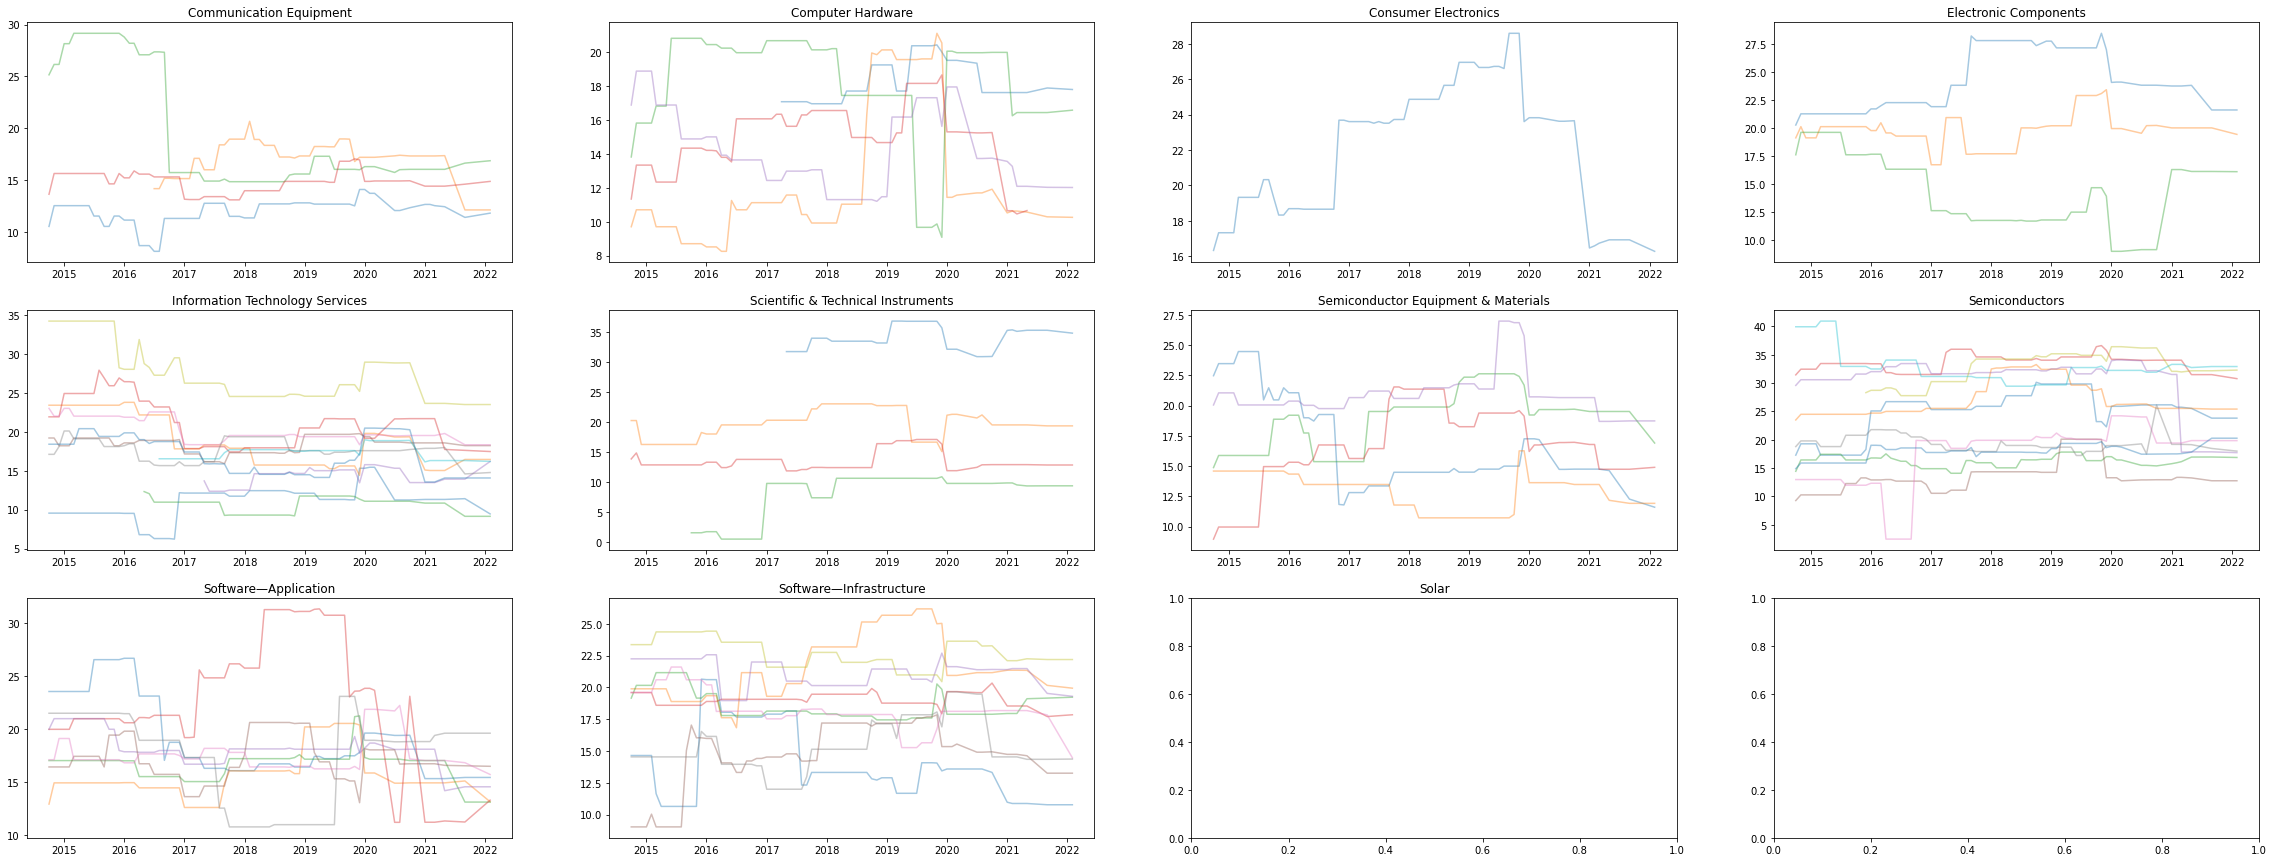

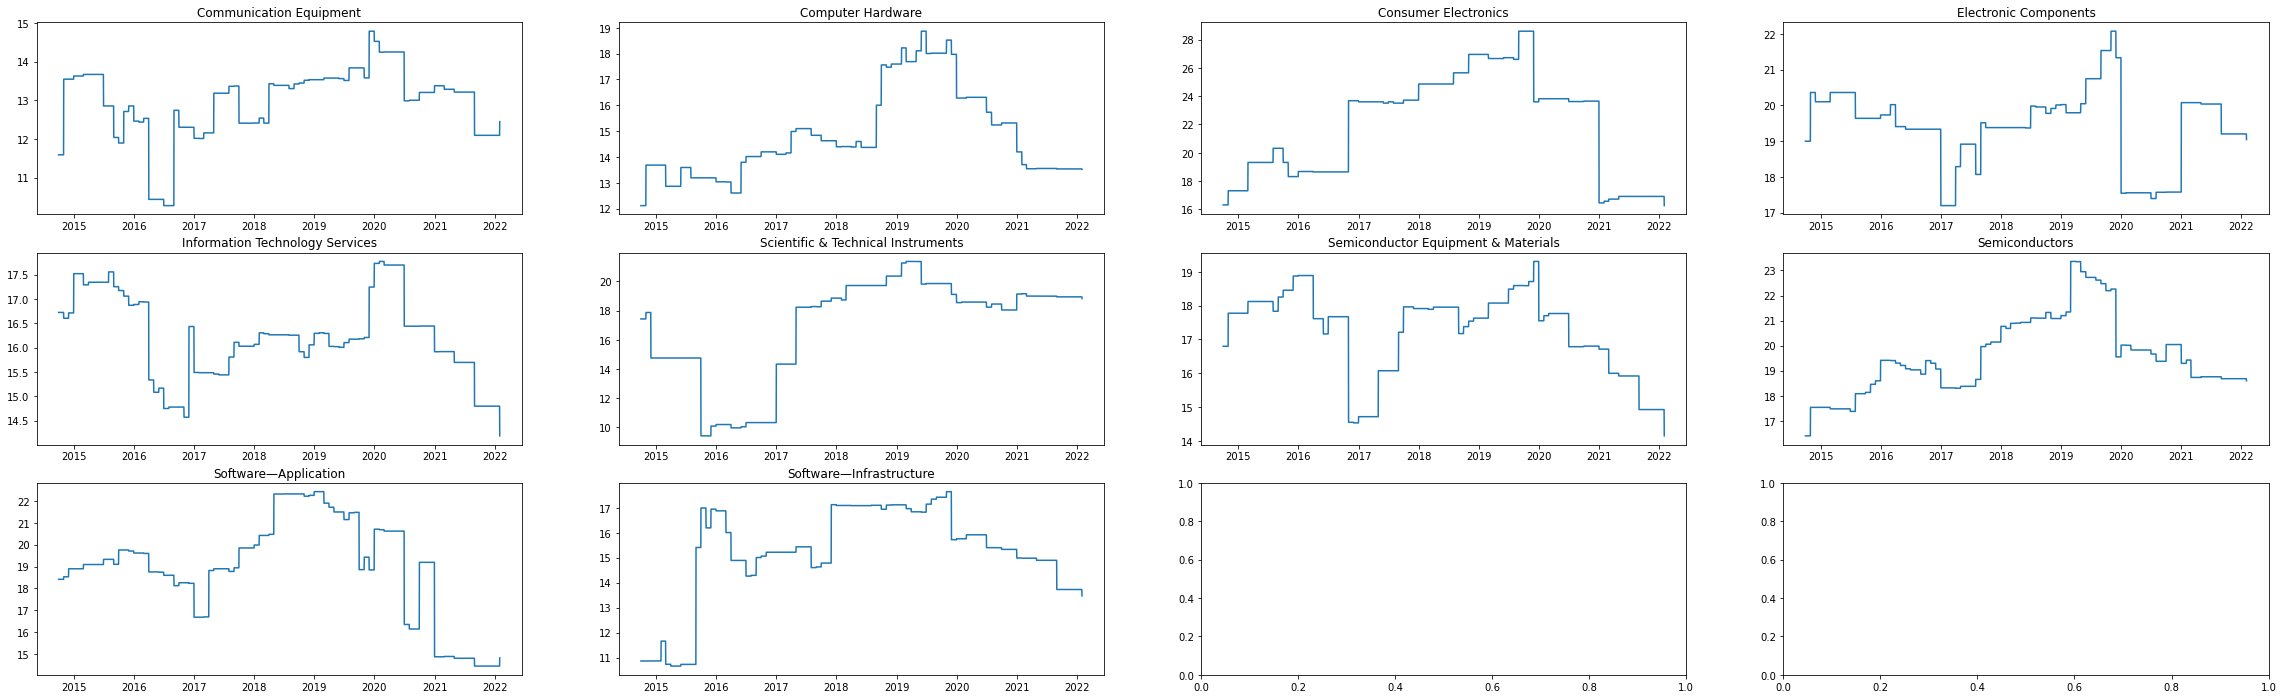

In [222]:
plot_esg_industry('Technology', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Technology', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/Technology_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)

# Healthcare

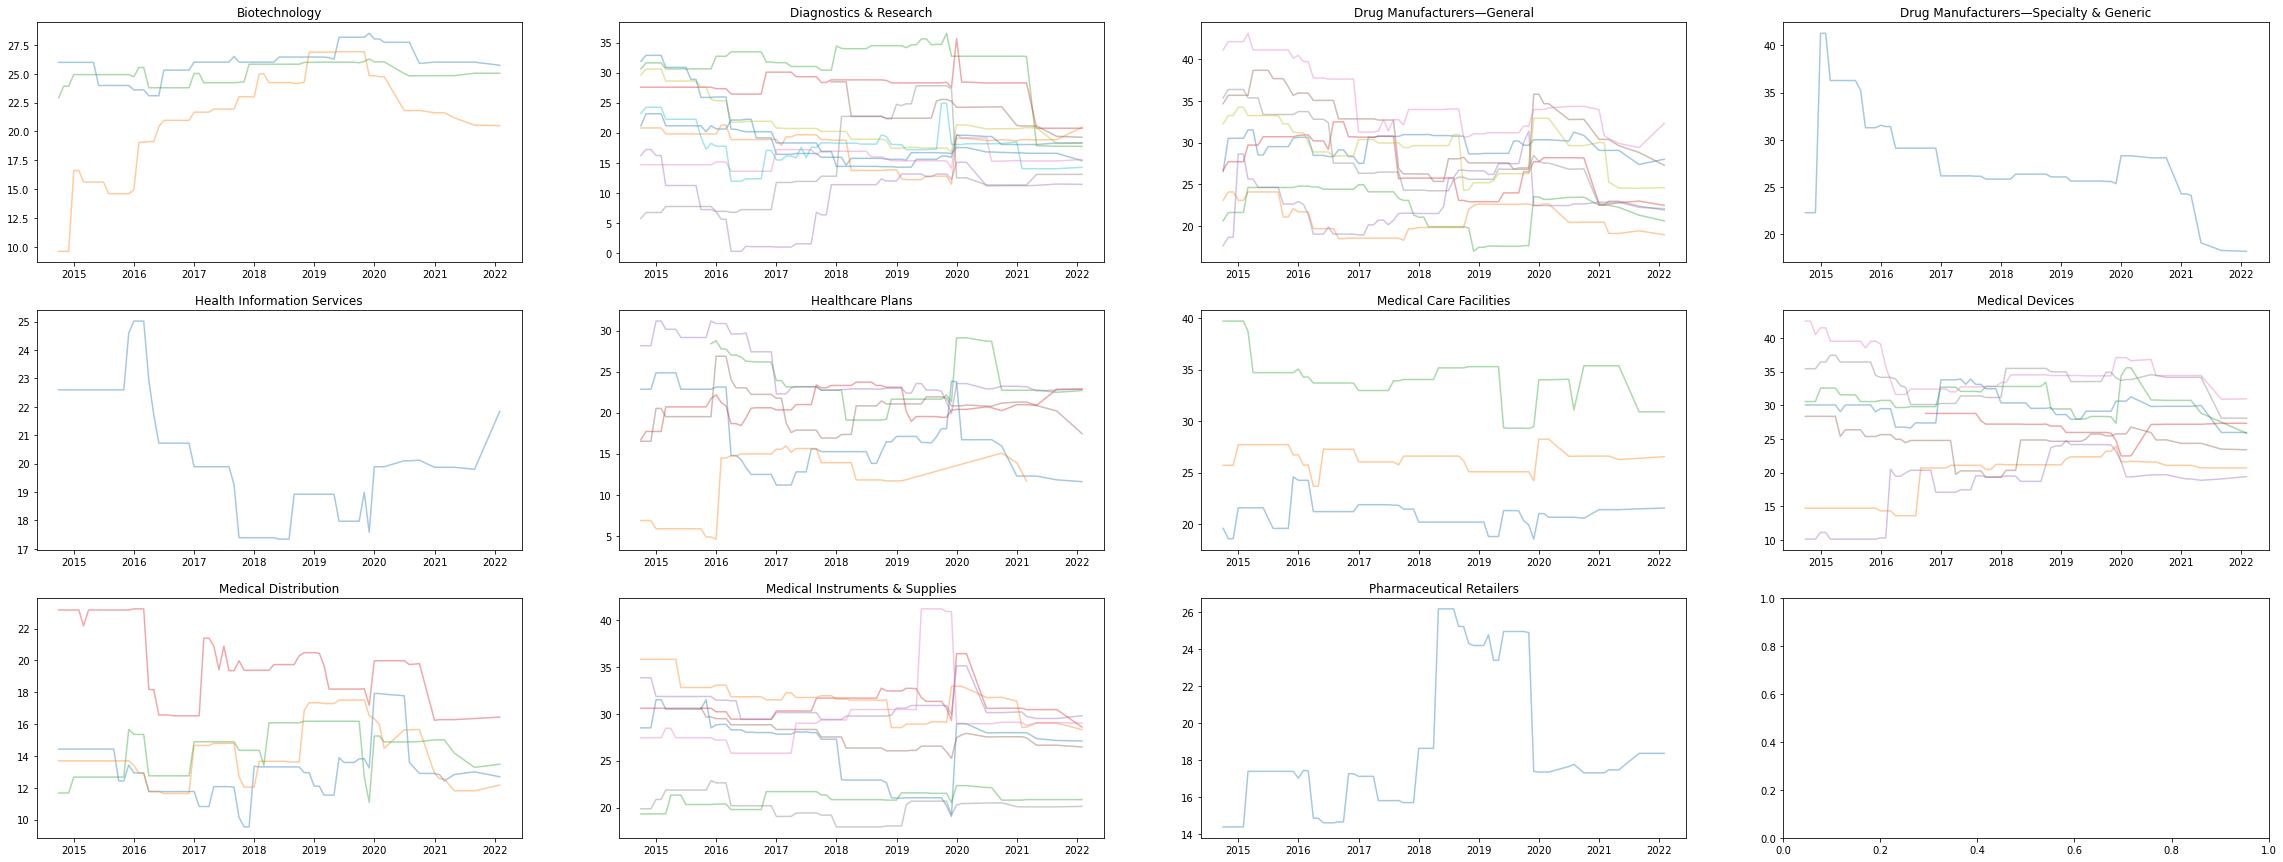

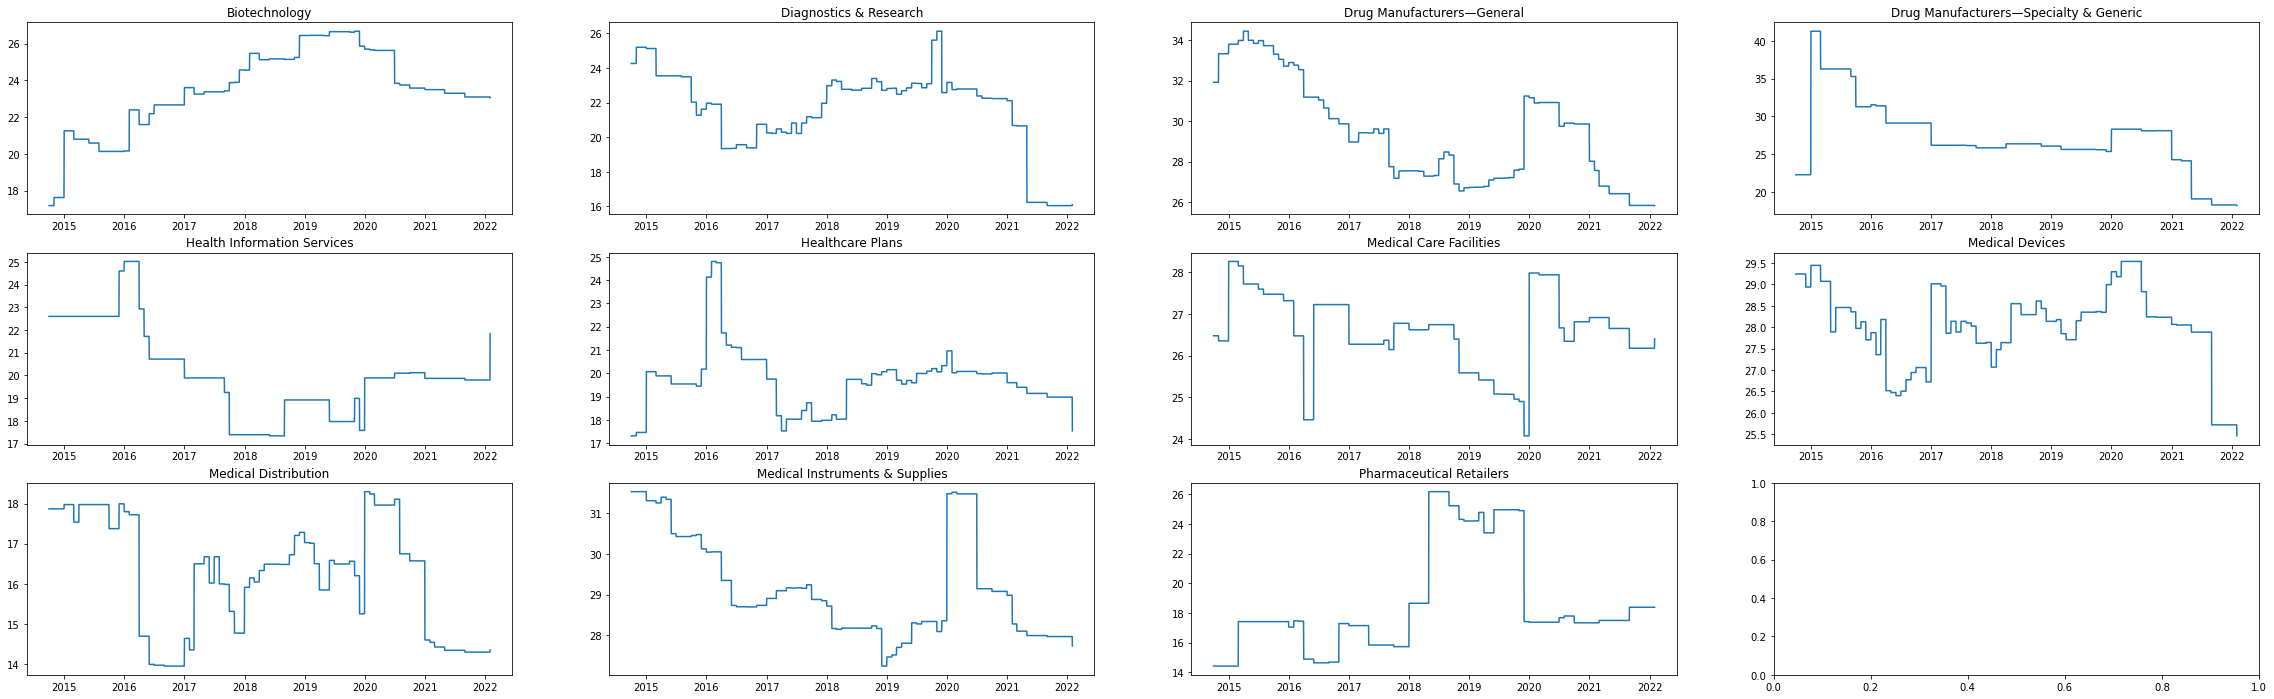

In [225]:
plot_esg_industry('Healthcare', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Healthcare', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/Healthcare_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)

# Real Estate

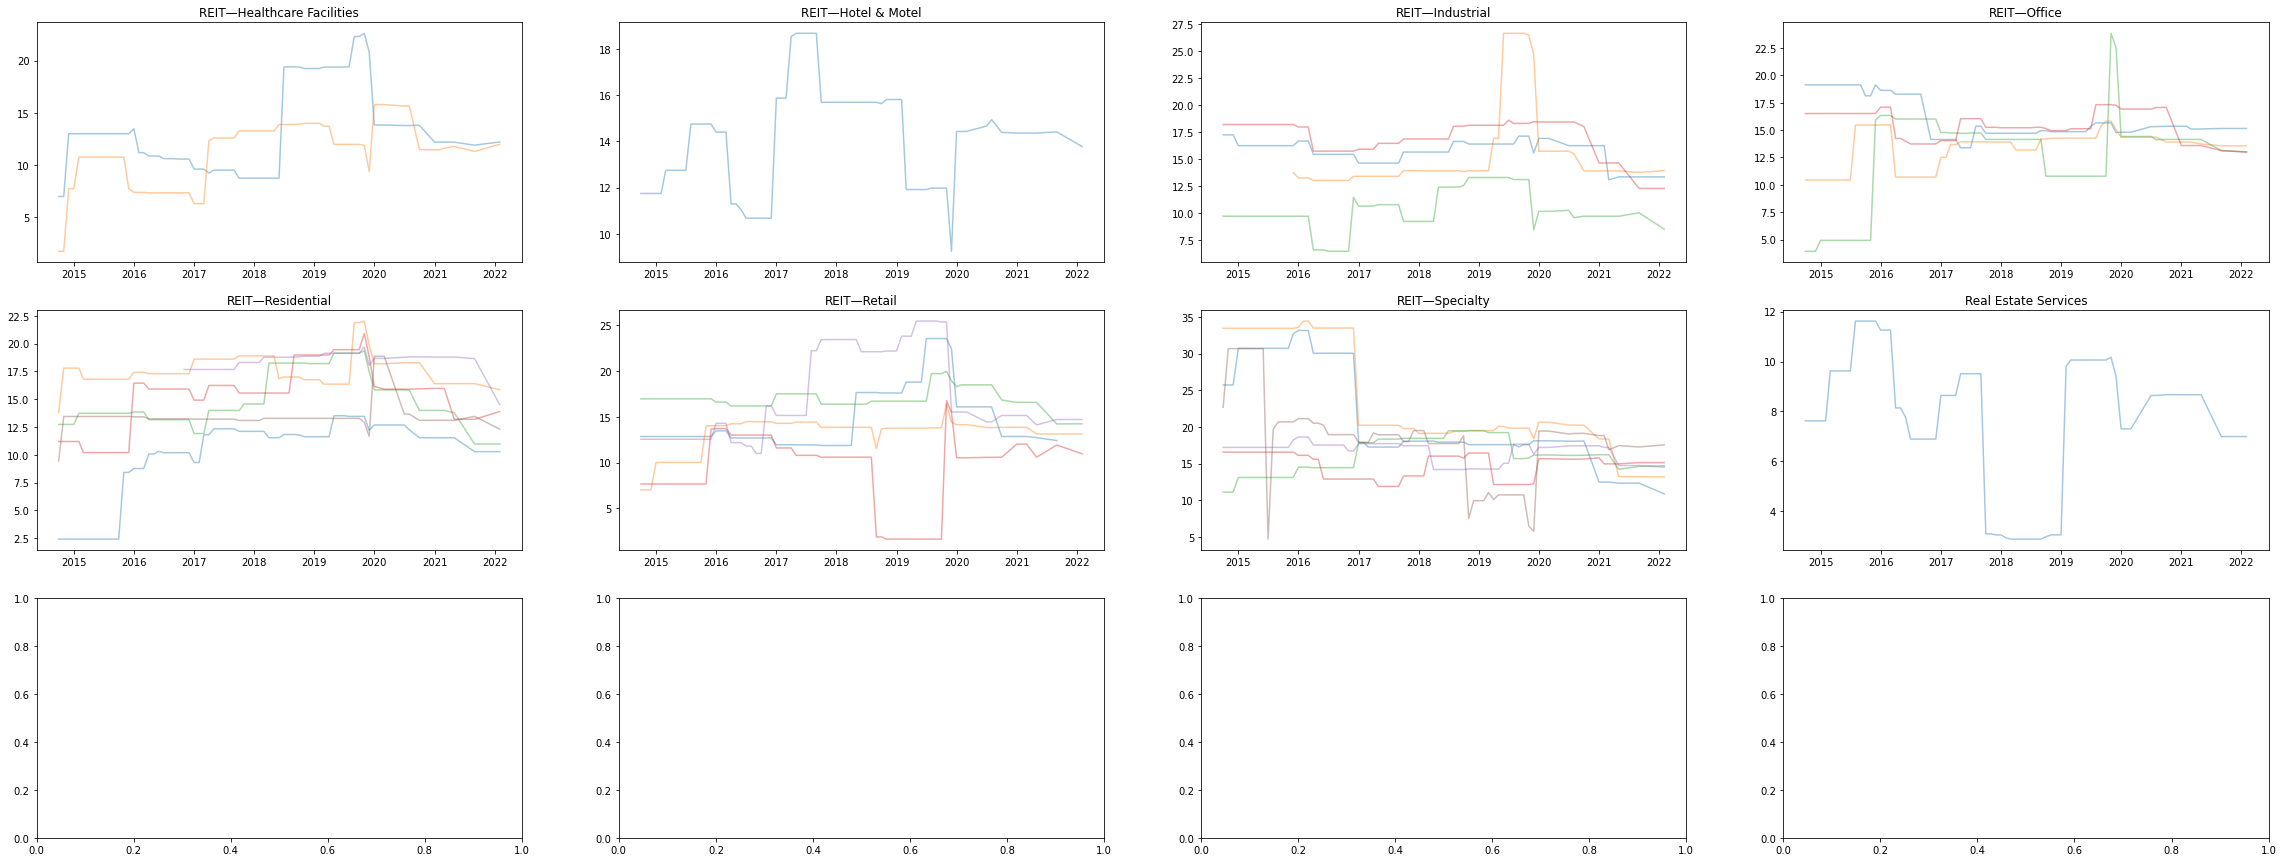

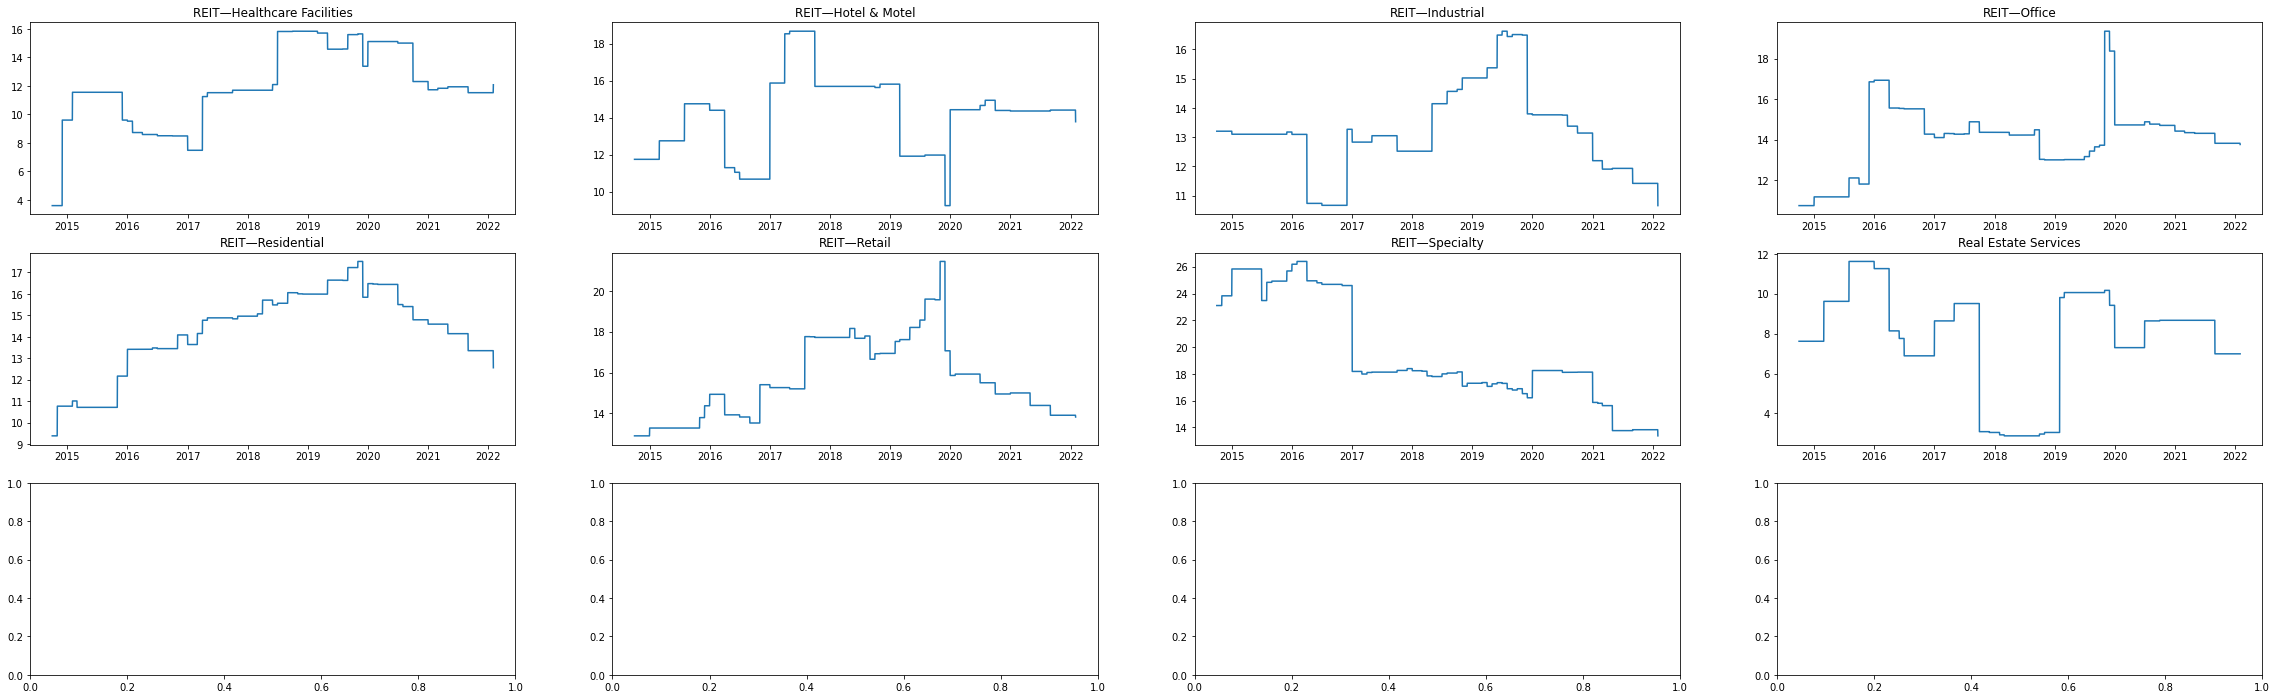

In [226]:
plot_esg_industry('Real Estate', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Real Estate', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/RealEstate_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)

# Communication Services

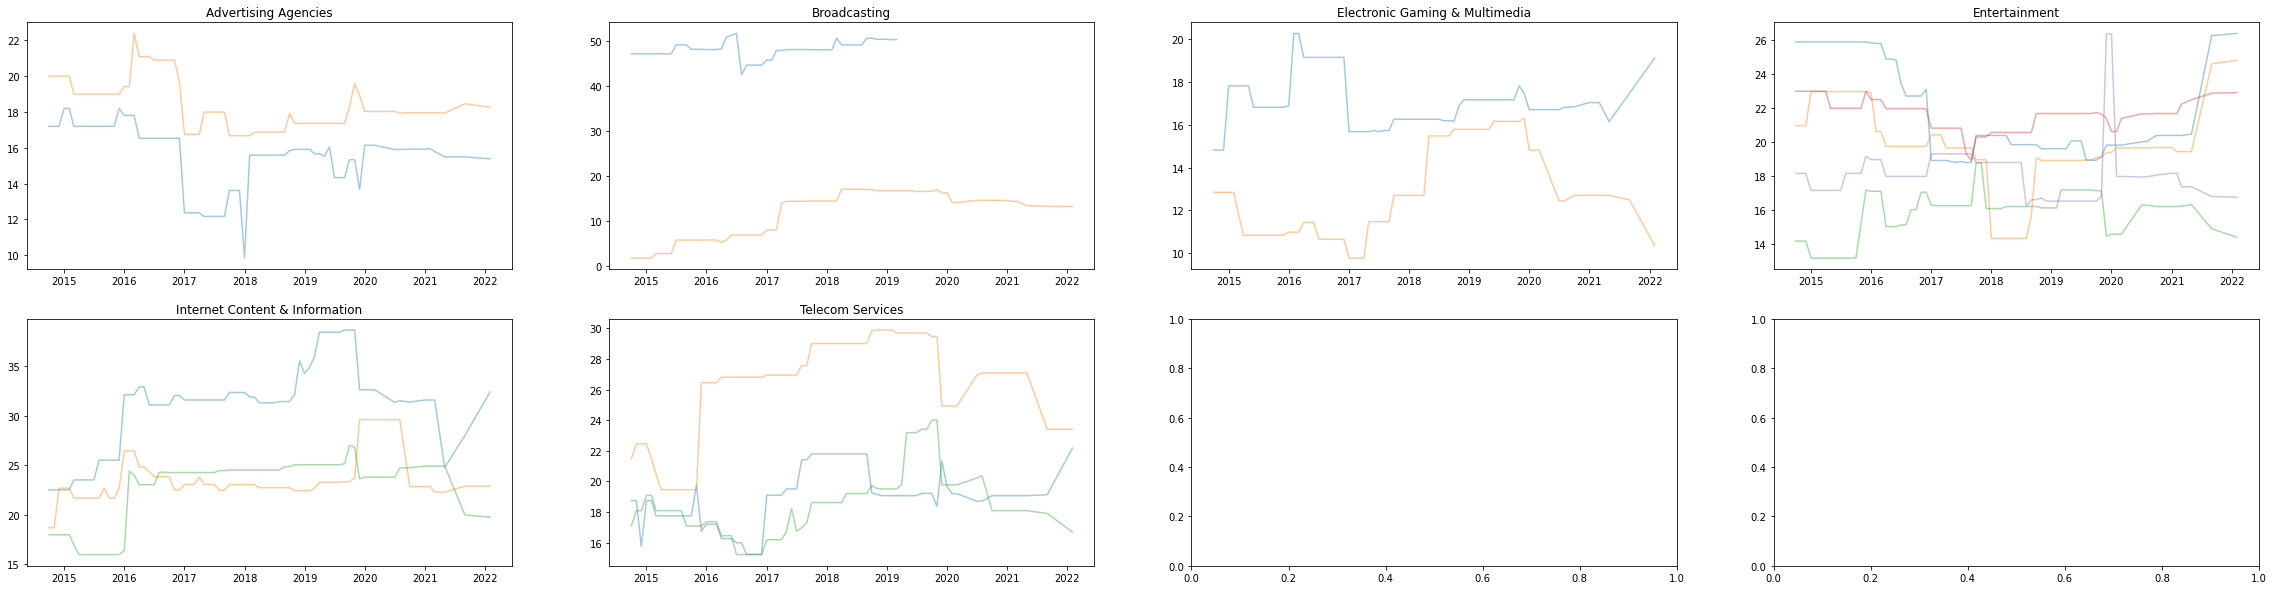

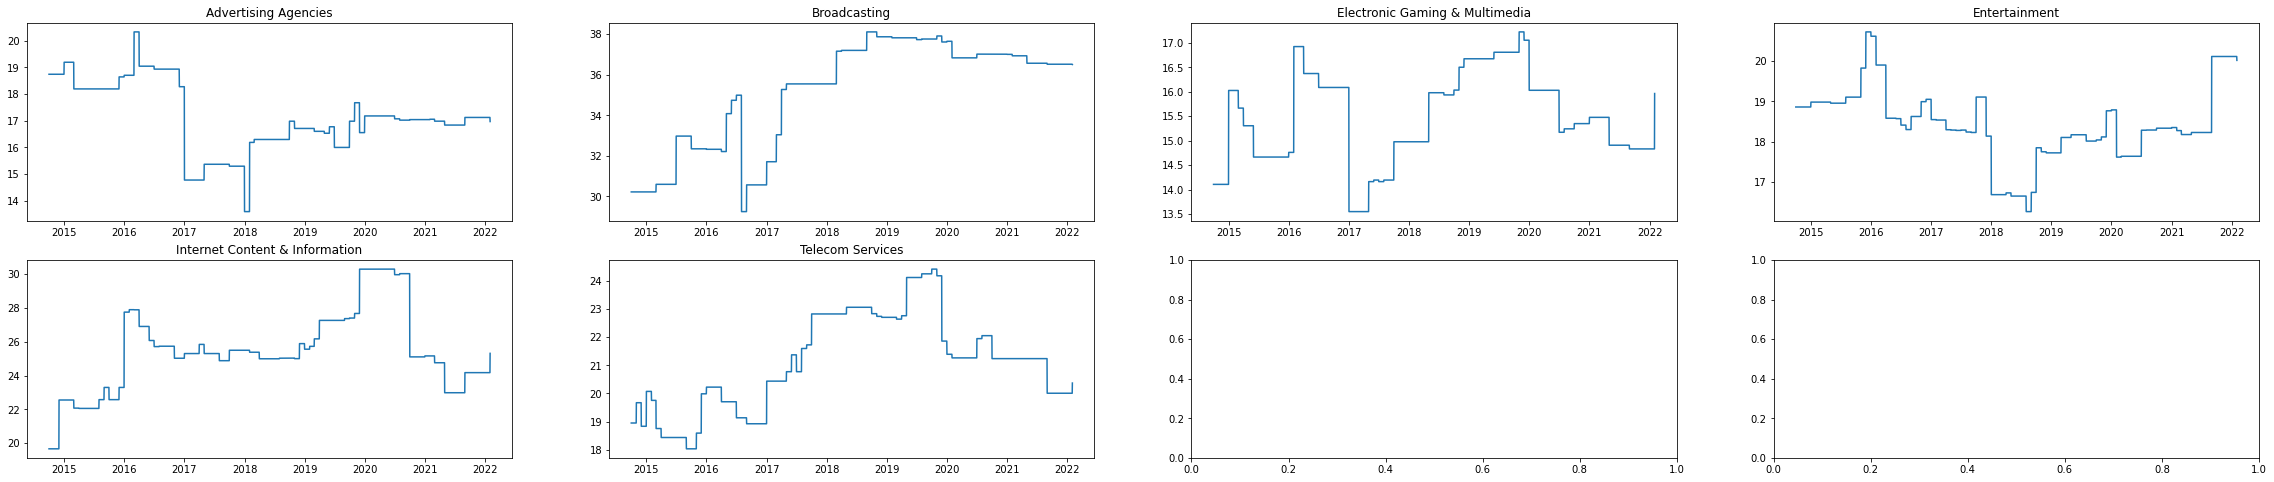

In [227]:
plot_esg_industry('Communication Services', asset_profiles, esg_pivot_shifted)
industrial_sector, all_observed = industry_index('Communication Services', asset_profiles, esg_pivot_shifted, marketcap)
k = industrial_sector.shape[1]
fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,4*(int(k/4)+1)))

for idx, industry in enumerate(industrial_sector.columns):

    j = idx % 4
    i = int(np.floor(idx/4))
    y = industrial_sector[industry]
    axs[i,j].plot(y[np.isfinite(y)])
    axs[i,j].set_title(industry)

industrial_sector_pkl = dict()
industrial_sector_pkl['data'] = industrial_sector
industrial_sector_pkl['index'] = all_observed

with open('../Yahoo/CommunicationServices_Industry.pkl', 'wb') as handle:
    pickle.dump(industrial_sector_pkl, handle)

In [120]:
sector_classification.keys()

dict_keys(['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology', 'Consumer Defensive', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy', 'Communication Services'])